In [1]:
import os
import random
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.optim.lr_scheduler import CosineAnnealingLR

In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# 1) Dataset 정의: 500×500 이미지를 PatchEmbedding 없이 그대로 사용
# ─────────────────────────────────────────────────────────────────────────────
class NoisyImageDataset(Dataset):
    def __init__(self, images, labels, lbl_min, lbl_max):
        """
        images: (N, 500, 500) numpy array, raw pixel values (0~4095)
        labels: (N,) numpy array, raw labels
        lbl_min, lbl_max: 레이블 Min–Max 정규화 상수
        """
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.float32)
        self.lbl_min = lbl_min
        self.lbl_max = lbl_max
        self.to_tensor = T.ToTensor()  # (H, W) → (1, H, W)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]   # (500, 500)
        lbl = self.labels[idx]   # float

        # 1) [0,4095] → [0,1]
        img_norm = img / 4095.0

        # 2) Grayscale → Tensor (1, 500, 500)
        img_tensor = self.to_tensor(img_norm)

        # 3) 레이블 Min–Max 정규화 → [-1,1]
        lbl_norm = (lbl - self.lbl_min) / (self.lbl_max - self.lbl_min + 1e-8)  # [0,1]
        lbl_scaled = lbl_norm * 2.0 - 1.0                                       # [-1,1]
        lbl_tensor = torch.tensor(lbl_scaled, dtype=torch.float32)

        return img_tensor, lbl_tensor


# ─────────────────────────────────────────────────────────────────────────────
# 2) ViT 모델 정의: 패치 크기 50, 3 Transformer 블록
# ─────────────────────────────────────────────────────────────────────────────
class ViT50_3block(nn.Module):
    def __init__(self,
                 img_size=500,
                 patch_size=50,
                 embed_dim=256,
                 depth=3,
                 num_heads=8,
                 mlp_dim=512,
                 num_classes=1):
        """
        img_size: 입력 이미지 해상도 (여기서는 500×500)
        patch_size: 각 패치 크기 (50×50)
        embed_dim: 패치 임베딩 차원(여기선 256)
        depth: Transformer Encoder 레이어 개수 (3개)
        num_heads: 멀티헤드 어텐션 헤드 수 (8개)
        mlp_dim: Transformer 내부 MLP 숨겨진 차원 (512)
        num_classes: 출력 노드 수 (회귀용이므로 1)
        """
        super().__init__()
        assert img_size % patch_size == 0, "Image size must be divisible by patch size."
        num_patches = (img_size // patch_size) ** 2  # (500/50)² = 10×10 = 100

        # 2-1) Patch Embedding: Conv2d(1→embed_dim, kernel=patch_size, stride=patch_size)
        self.patch_embed = nn.Conv2d(
            in_channels=1,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )
        # 결과: (B, embed_dim, 10, 10)

        # 2-2) Class Token 학습 파라미터
        #   (시퀀스 앞에 붙일 학습 가능한 토큰, shape=(1,1,embed_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # 2-3) Positional Embedding: (1, num_patches+1, embed_dim)
        #   시퀀스 길이 = 패치 수(100) + cls 토큰(1) = 101
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        # 2-4) Transformer Encoder: 3개의 레이어 (nn.TransformerEncoderLayer 반복)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=mlp_dim,
            dropout=0.0,
            activation='gelu',
            batch_first=False  # (seq_len, batch, embed_dim) 입력을 기대
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # 2-5) 회귀용 Head: Transformer 마지막 CLS 출력(256차원) → Linear(256→1)
        self.head = nn.Linear(embed_dim, num_classes)

        # 2-6) 파라미터 초기화
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)

    def forward(self, x):
        """
        x: (B, 1, 500, 500)
        """
        B = x.size(0)

        # (1) Patch Embedding
        #    입력 (B,1,500,500) → Conv2d → (B, embed_dim, 10, 10)
        x = self.patch_embed(x)

        # (2) Flatten & Transpose
        #    (B, embed_dim, 10, 10) → (B, embed_dim, 100) → (B, 100, embed_dim)
        x = x.flatten(2).transpose(1, 2)

        # (3) CLS 토큰 결합
        #    cls_token (1,1,embed_dim) → expand → (B,1,embed_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        #    (B,1,embed_dim) + (B,100,embed_dim) → (B,101,embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)

        # (4) Positional Embedding 추가
        #    pos_embed (1,101,embed_dim) → 브로드캐스트 → (B,101,embed_dim)
        x = x + self.pos_embed

        # (5) Transformer 인코더 expects (seq_len, batch, embed_dim)
        x = x.transpose(0, 1)  # (101, B, embed_dim)
        x = self.transformer(x)  # (101, B, embed_dim)

        # (6) CLS 토큰 출력만 사용: x[0] → (B, embed_dim)
        cls_out = x[0]

        # (7) 회귀 Head: (B, embed_dim) → (B, 1) → squeeze → (B,)
        out = self.head(cls_out).squeeze(-1)
        return out

Total samples: 56700
Train: 39690, Val: 5670, Test: 11340


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch   1 | Train Loss: 0.025982 | Val Loss: 0.001777 | LR: 0.001
  → New best val loss: 0.001777, saved to ./best_vit50_3block_bulk_0_270_final.pth
Epoch   2 | Train Loss: 0.001223 | Val Loss: 0.000685 | LR: 0.001
  → New best val loss: 0.000685, saved to ./best_vit50_3block_bulk_0_270_final.pth
Epoch   3 | Train Loss: 0.001018 | Val Loss: 0.001039 | LR: 0.001
Epoch   4 | Train Loss: 0.000842 | Val Loss: 0.001135 | LR: 0.001
Epoch   5 | Train Loss: 0.000853 | Val Loss: 0.000520 | LR: 0.001
  → New best val loss: 0.000520, saved to ./best_vit50_3block_bulk_0_270_final.pth
Epoch   6 | Train Loss: 0.000732 | Val Loss: 0.000683 | LR: 0.001
Epoch   7 | Train Loss: 0.000623 | Val Loss: 0.001260 | LR: 0.001
Epoch   8 | Train Loss: 0.000653 | Val Loss: 0.000594 | LR: 0.001
Epoch   9 | Train Loss: 0.000518 | Val Loss: 0.000490 | LR: 0.001
  → New best val loss: 0.000490, saved to ./best_vit50_3block_bulk_0_270_final.pth
Epoch  10 | Train Loss: 0.000474 | Val Loss: 0.000321 | LR: 0.001
  → New 

/tmp/ipykernel_38169/3907947417.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


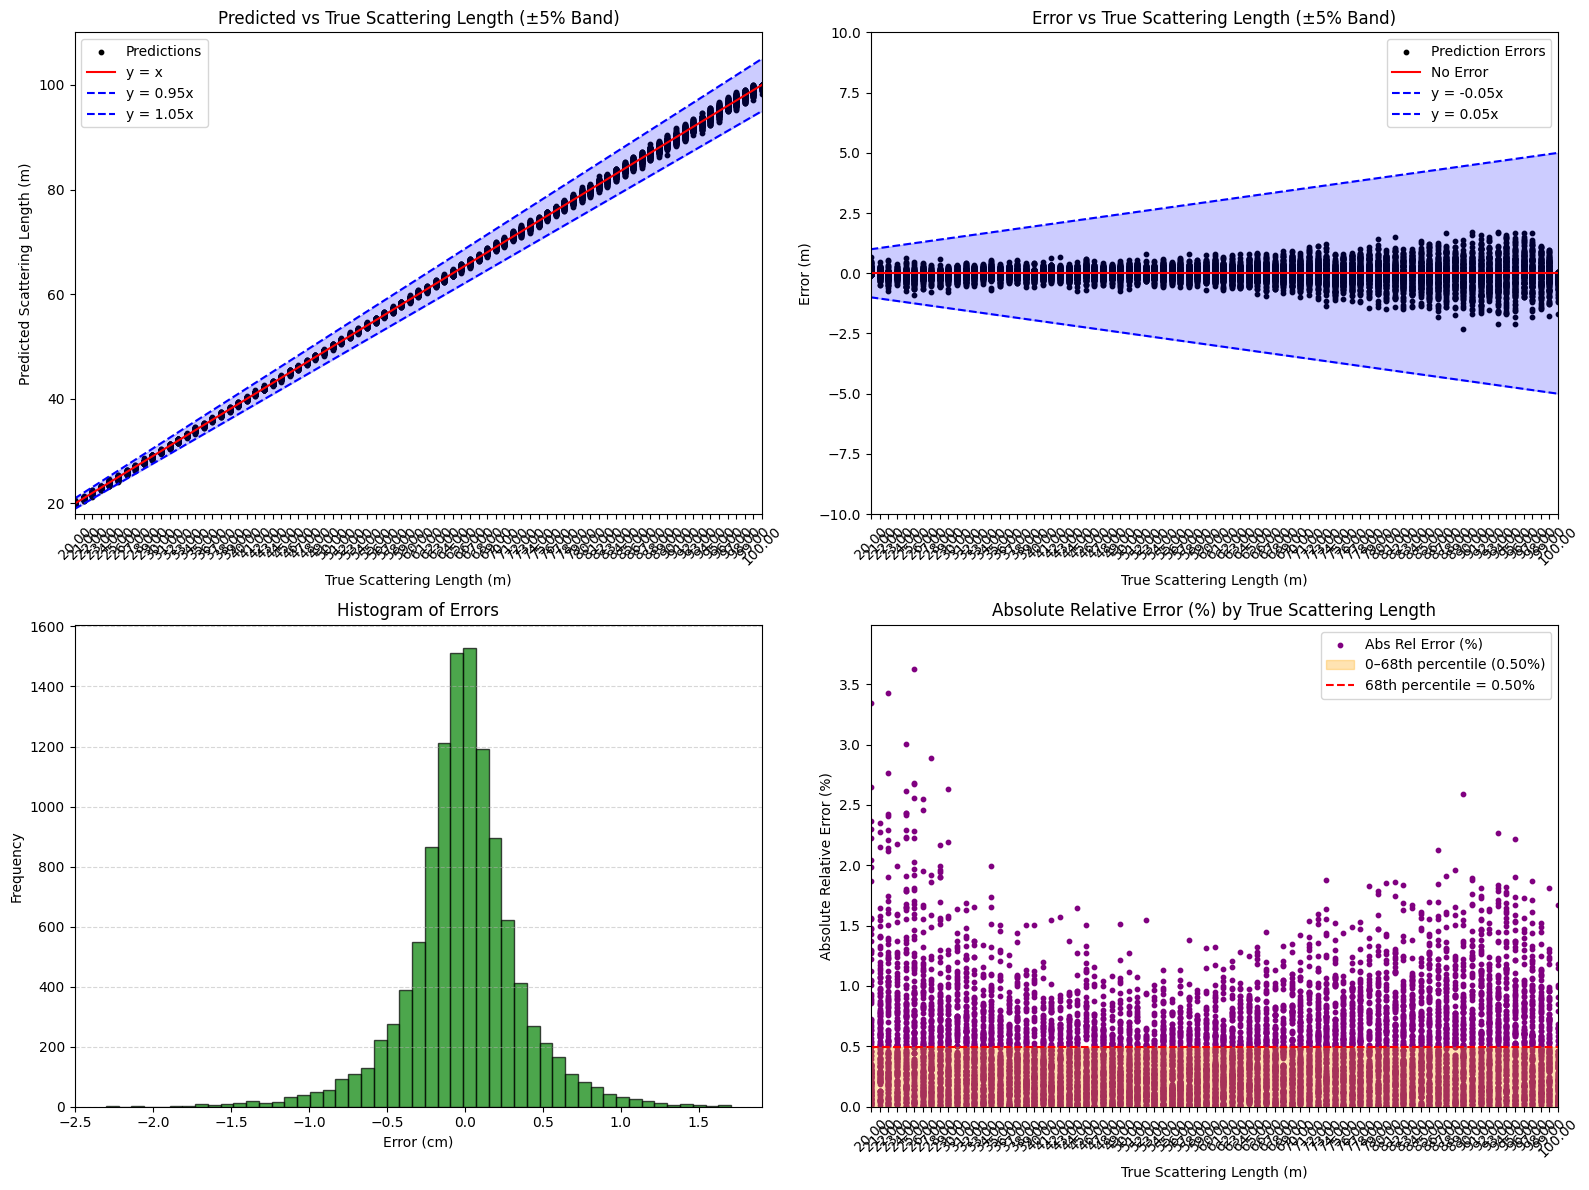

In [3]:
# ─────────────────────────────────────────────────────────────────────────────
# 3) train_validate 함수: Early Stopping + ReduceLROnPlateau + AdamW
# ─────────────────────────────────────────────────────────────────────────────
def train_validate(model, train_loader, val_loader, criterion, optimizer, scheduler,
                   num_epochs=100, patience=10, save_path='./best_vit50_3block.pth'):
    device = next(model.parameters()).device
    best_val_loss = float('inf')
    wait = 0

    for epoch in range(1, num_epochs + 1):
        # ─── Training ─────────────────────────────────────────────────────
        model.train()
        running_train_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)   # (B, 1, 500, 500)
            labels = labels.to(device)   # (B,)

            optimizer.zero_grad()
            outputs = model(images)      # (B,)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * images.size(0)

        # ─── Validation ───────────────────────────────────────────────────
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)

        train_loss = running_train_loss / len(train_loader.dataset)
        val_loss   = running_val_loss   / len(val_loader.dataset)
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {lr:.6g}")

        # ─── ReduceLROnPlateau 스케줄러 업데이트 ─────────────────────────────
        #    scheduler.step(val_loss) → val_loss 기반으로 LR 감소
        scheduler.step(val_loss)

        # ─── Early Stopping 및 Best Model 저장 ─────────────────────────────
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
            torch.save(model.state_dict(), save_path)
            print(f"  → New best val loss: {best_val_loss:.6f}, saved to {save_path}")
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    return model


# ─────────────────────────────────────────────────────────────────────────────
# 4) 전체 파이프라인: 데이터 로드 → DataLoader → 모델 정의 → 학습 → 평가 → 시각화
# ─────────────────────────────────────────────────────────────────────────────
if __name__ == '__main__':
    # (A) HDF5 로드
    hdf5_path = '/home/work/CamSim/SimData/Bulk_V1.0/h5/ori_270.h5'
    with h5py.File(hdf5_path, 'r') as f:
        raw_images = f['images'][:]   # (N, 500, 500)
        raw_labels = f['labels'][:]   # (N,)

    print(f"Total samples: {raw_images.shape[0]}")

    # 레이블 Min/Max 계산
    lbl_min = raw_labels.min()
    lbl_max = raw_labels.max()

    # (B) Dataset & DataLoader 생성 (60/20/20 split)
    dataset = NoisyImageDataset(raw_images, raw_labels, lbl_min, lbl_max)
    unique_labels = np.unique(raw_labels)

    train_indices, val_indices, test_indices = [], [], []
    for lbl in unique_labels:
        inds = np.where(raw_labels == lbl)[0].tolist()
        random.shuffle(inds)
        n = len(inds)
        n_test = int(n * 0.20)
        n_val  = int(n * 0.10)
        test_indices.extend(inds[:n_test])
        val_indices.extend(inds[n_test:n_test + n_val])
        train_indices.extend(inds[n_test + n_val:])

    batch_size = 32
    train_loader = DataLoader(Subset(dataset, train_indices),
                              batch_size=batch_size, shuffle=True,
                              num_workers=4, pin_memory=True)
    val_loader   = DataLoader(Subset(dataset, val_indices),
                              batch_size=batch_size, shuffle=False,
                              num_workers=4, pin_memory=True)
    test_loader  = DataLoader(Subset(dataset, test_indices),
                              batch_size=batch_size, shuffle=False,
                              num_workers=4, pin_memory=True)

    print(f"Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_indices)}")

    # (C) 모델 정의: ViT50_3block
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ViT50_3block(
        img_size=300,
        patch_size=30,
        embed_dim=64,
        depth=4,
        num_heads=4,
        mlp_dim=256,
        num_classes=1
    ).to(device)

    # (D) Optimizer & Scheduler: AdamW + ReduceLROnPlateau
    criterion = nn.MSELoss()
    optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer,
                                  mode='min',
                                  factor=0.5,
                                  patience=3,
                                  verbose=True)
    # (E) 모델 학습
    best_model_path = './best_vit50_3block_bulk_0_270_final.pth'
    model = train_validate(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler,
        num_epochs=130,
        patience=7,
        save_path=best_model_path
    )

    # (F) 테스트 세트 평가
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()

    true_vals = []
    pred_vals = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)   # (B, 1, 500, 500)
            labels = labels.to(device)   # (B,)
            outputs = model(images)      # (B,)

            # 정규화 복원 → 원래 스케일로
            labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
            preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

            true_vals.extend(labels_orig.tolist())
            pred_vals.extend(preds_orig.tolist())

    true_vals = np.array(true_vals)
    pred_vals = np.array(pred_vals)
    errors = pred_vals - true_vals
    abs_rel_errors = np.abs(errors / true_vals) * 100.0

    # (G) 결과 시각화
    plt.figure(figsize=(16, 12))
    mn = min(true_vals.min(), pred_vals.min())
    mx = max(true_vals.max(), pred_vals.max())
    unique_true_labels = np.unique(true_vals)

    # 1) Predicted vs True with ±5% Band
    ax1 = plt.subplot(2, 2, 1)
    ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
    ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
    ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
    ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
    ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
    ax1.set_xticks(unique_true_labels)
    ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
    ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
    ax1.set_xlabel("True Scattering Length (m)")
    ax1.set_ylabel("Predicted Scattering Length (m)")
    ax1.set_xlim(mn, mx)
    ax1.set_ylim(mn * 0.9, mx * 1.1)
    ax1.legend()

    # 2) Error vs True with ±5% Band
    ax2 = plt.subplot(2, 2, 2)
    ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
    ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
    ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
    ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
    ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
    ax2.set_xticks(unique_true_labels)
    ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
    ax2.set_title("Error vs True Scattering Length (±5% Band)")
    ax2.set_xlabel("True Scattering Length (m)")
    ax2.set_ylabel("Error (m)")
    ax2.set_xlim(mn, mx)
    ax2.set_ylim(-0.1 * mx, 0.1 * mx)
    ax2.legend()

    # 3) Histogram of Errors (50 bins)
    ax3 = plt.subplot(2, 2, 3)
    bins = np.linspace(errors.min(), errors.max(), 50)
    ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
    ax3.set_title("Histogram of Errors")
    ax3.set_xlabel("Error (cm)")
    ax3.set_ylabel("Frequency")
    ax3.grid(axis='y', linestyle='--', alpha=0.5)

    # 4) Absolute Relative Error (%) by True with 68th Percentile
    ax4 = plt.subplot(2, 2, 4)
    ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
    perc68 = np.percentile(abs_rel_errors, 68)
    ax4.fill_between([mn, mx], 0, perc68, color='orange', alpha=0.3,
                     label=f'0–68th percentile ({perc68:.2f}%)')
    ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
               label=f'68th percentile = {perc68:.2f}%')
    ax4.set_xticks(unique_true_labels)
    ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
    ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
    ax4.set_xlabel("True Scattering Length (m)")
    ax4.set_ylabel("Absolute Relative Error (%)")
    ax4.set_xlim(mn, mx)
    ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
    ax4.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
#only image

In [6]:
hdf5_path = '/home/work/CamSim/SimData/Bulk_V1.0/h5/ori_270.h5'
with h5py.File(hdf5_path, 'r') as f:
    raw_images = f['images'][:]   # (N, 500, 500)
    raw_labels = f['labels'][:]   # (N,)

print(f"Total samples: {raw_images.shape[0]}")

# 레이블 Min/Max 계산
lbl_min = raw_labels.min()
lbl_max = raw_labels.max()

# (B) Dataset & DataLoader 생성 (60/20/20 split)
dataset = NoisyImageDataset(raw_images, raw_labels, lbl_min, lbl_max)
unique_labels = np.unique(raw_labels)

train_indices, val_indices, test_indices = [], [], []
for lbl in unique_labels:
    inds = np.where(raw_labels == lbl)[0].tolist()
    random.shuffle(inds)
    n = len(inds)
    n_test = int(n * 0.40)
    n_val  = int(n * 0.10)
    test_indices.extend(inds[:n_test])
    val_indices.extend(inds[n_test:n_test + n_val])
    train_indices.extend(inds[n_test + n_val:])

batch_size = 32
train_loader = DataLoader(Subset(dataset, train_indices),
                            batch_size=batch_size, shuffle=True,
                            num_workers=4, pin_memory=True)
val_loader   = DataLoader(Subset(dataset, val_indices),
                            batch_size=batch_size, shuffle=False,
                            num_workers=4, pin_memory=True)
test_loader  = DataLoader(Subset(dataset, test_indices),
                            batch_size=batch_size, shuffle=False,
                            num_workers=4, pin_memory=True)

print(f"Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_indices)}")

Total samples: 56700
Train: 28350, Val: 5670, Test: 22680


In [7]:
best_model_path = './best_vit50_3block_bulk_0_270.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT50_3block(
    img_size=300,
    patch_size=30,
    embed_dim=64,
    depth=4,
    num_heads=4,
    mlp_dim=256,
    num_classes=1
).to(device)
# (F) 테스트 세트 평가
checkpoint = torch.load(best_model_path, map_location=device)

# 체크포인트가 딕셔너리 형태인지(state dict만인지) 확인
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    # {'model_state_dict': ..., 'optimizer_state_dict': ..., 'val_loss': ..., ...} 형태
    model.load_state_dict(checkpoint['model_state_dict'])
    if 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint.get('epoch', 0) + 1
    best_val_loss = checkpoint.get('val_loss', float('inf'))
    print(f"Loaded checkpoint from epoch {checkpoint.get('epoch', 0)}. Continuing from epoch {start_epoch}.")
else:
    # 단순히 model.state_dict()만 저장된 경우
    model.load_state_dict(checkpoint)
    start_epoch = 1
    best_val_loss = float('inf')
    print("Loaded state_dict-only checkpoint. Starting from epoch 1.")

model.eval()

true_vals = []
pred_vals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)   # (B, 1, 500, 500)
        labels = labels.to(device)   # (B,)
        outputs = model(images)      # (B,)

        # 정규화 복원 → 원래 스케일로
        labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
        preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

        true_vals.extend(labels_orig.tolist())
        pred_vals.extend(preds_orig.tolist())

true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)
errors = pred_vals - true_vals
abs_rel_errors = np.abs(errors / true_vals) * 100.0

Loaded checkpoint from epoch 47. Continuing from epoch 48.


/tmp/ipykernel_38169/603823391.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device)


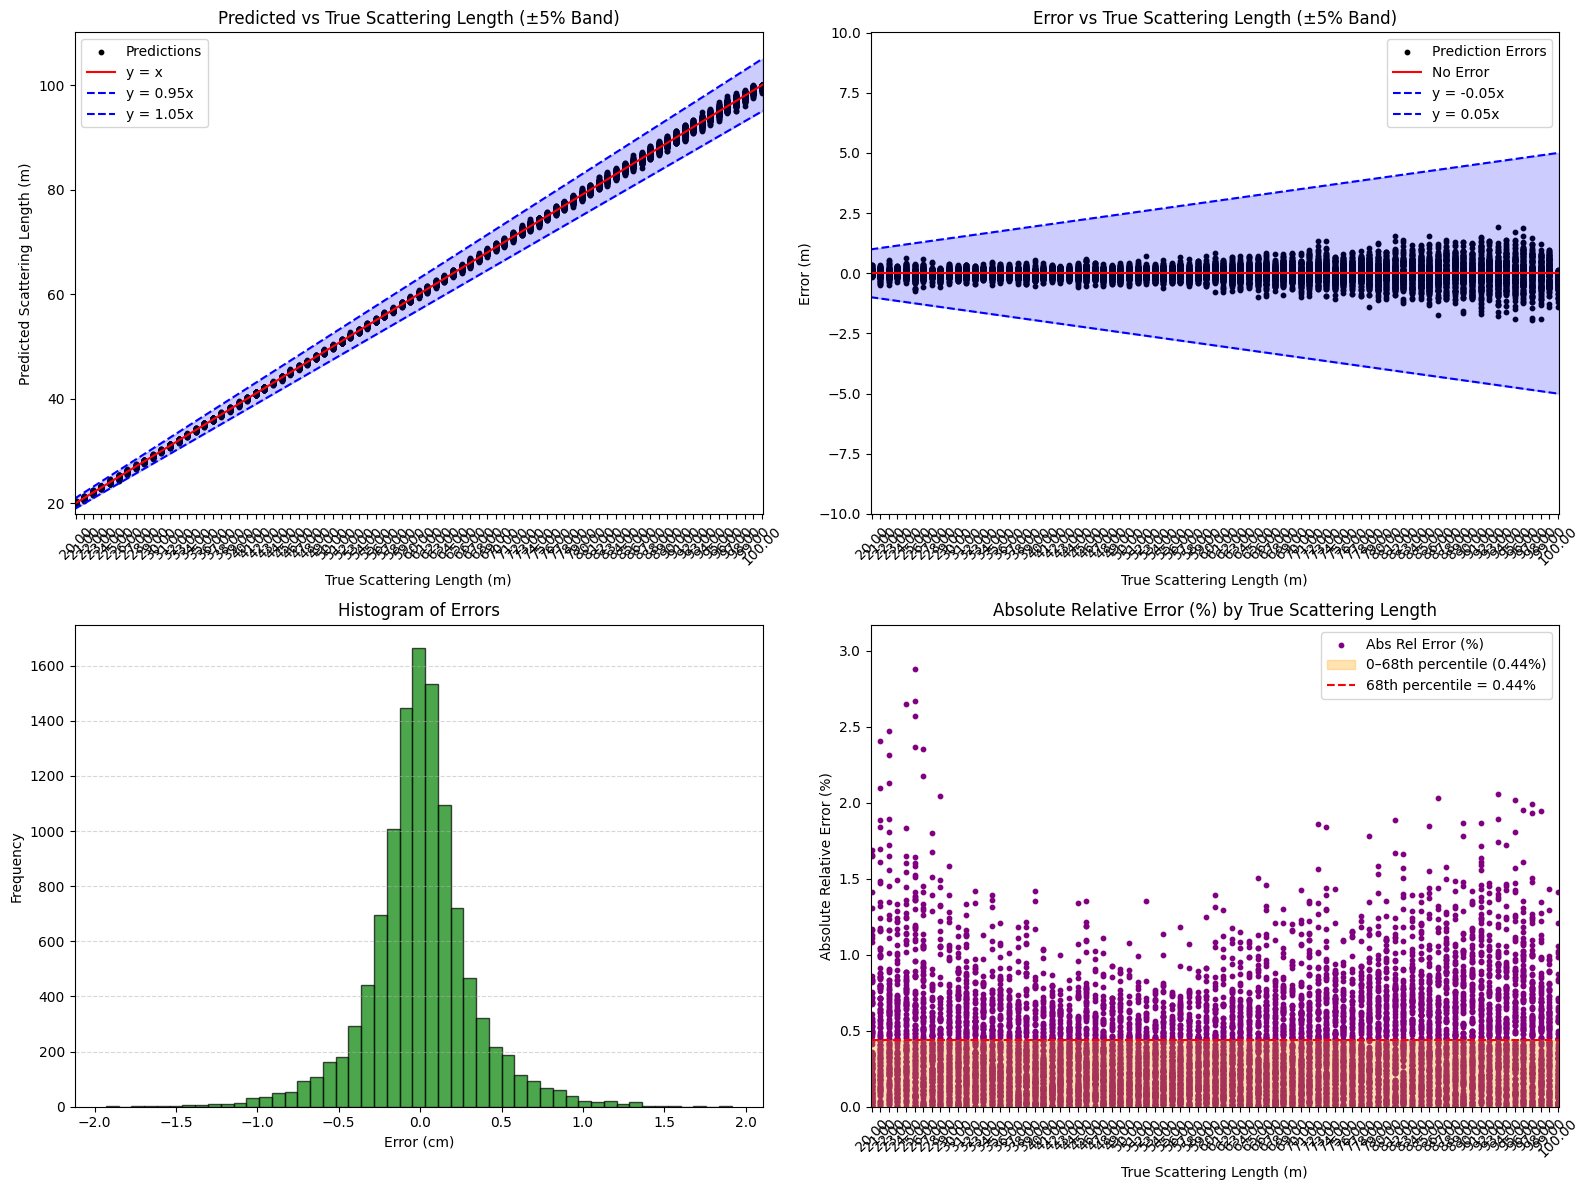

In [8]:
true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)
errors = pred_vals - true_vals
abs_rel_errors = np.abs(errors / true_vals) * 100.0

# (G) 결과 시각화
plt.figure(figsize=(16, 12))
mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())
unique_true_labels = np.unique(true_vals)

# 1) Predicted vs True with ±5% Band
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (m)")
ax1.set_ylabel("Predicted Scattering Length (m)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()

# 2) Error vs True with ±5% Band
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (m)")
ax2.set_ylabel("Error (m)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()

# 3) Histogram of Errors (50 bins)
ax3 = plt.subplot(2, 2, 3)
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# 4) Absolute Relative Error (%) by True with 68th Percentile
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
perc68 = np.percentile(abs_rel_errors, 68)
ax4.fill_between([mn, mx], 0, perc68, color='orange', alpha=0.3,
                    label=f'0–68th percentile ({perc68:.2f}%)')
ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
            label=f'68th percentile = {perc68:.2f}%')
ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (m)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
ax4.legend()

plt.tight_layout()
plt.show()

posx and posy should be finite values
posx and posy should be finite values


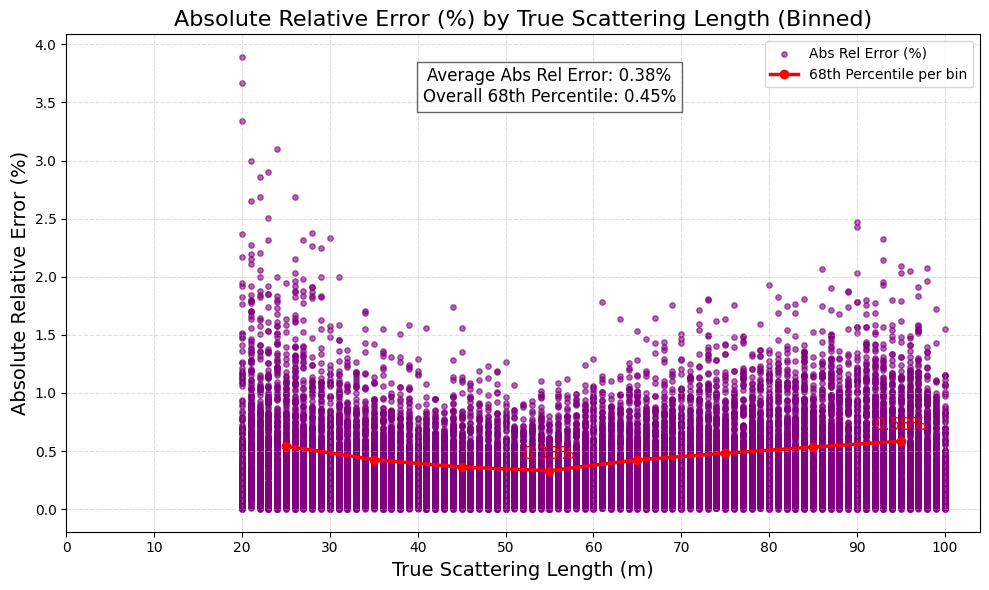

In [10]:
# 10미터 단위로 비닝
bins = np.arange(0, true_vals.max() + 10, 10)  # 0, 10, 20, 30, ...
bin_centers = (bins[:-1] + bins[1:]) / 2       # 각 bin의 중앙값

# 각 bin에서 68% percentile 계산
percentiles_68 = []
for i in range(len(bins)-1):
    bin_mask = (true_vals >= bins[i]) & (true_vals < bins[i+1])
    if np.sum(bin_mask) > 0:
        perc68_bin = np.percentile(abs_rel_errors[bin_mask], 68)
    else:
        perc68_bin = np.nan  # 빈 구간은 NaN 처리
    percentiles_68.append(perc68_bin)

percentiles_68 = np.array(percentiles_68)

# 평균 및 전체 범위의 68% percentile 계산
avg_abs_rel_error = np.mean(abs_rel_errors)
overall_perc68 = np.percentile(abs_rel_errors, 68)

# 그림 그리기
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(true_vals, abs_rel_errors, s=15, color='purple', alpha=0.6, label='Abs Rel Error (%)')

# 68% percentile line per bin
plt.plot(bin_centers, percentiles_68, color='red', linewidth=2.5, marker='o', label='68th Percentile per bin')

# 텍스트 표시 (첫 번째, 중간, 마지막 bin의 값 예시로 표시)
for idx in [0, len(bin_centers)//2, -1]:
    plt.text(bin_centers[idx], percentiles_68[idx]+0.1, f"{percentiles_68[idx]:.2f}%",
             fontsize=12, color='red', ha='center')

# 평균 및 전체 68% percentile 추가 텍스트
plt.text(bin_centers[len(bin_centers)//2], max(abs_rel_errors)*0.9,
         f"Average Abs Rel Error: {avg_abs_rel_error:.2f}%\n"
         f"Overall 68th Percentile: {overall_perc68:.2f}%",
         fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=0.6))

plt.xlabel("True Scattering Length (m)", fontsize=14)
plt.ylabel("Absolute Relative Error (%)", fontsize=14)
plt.title("Absolute Relative Error (%) by True Scattering Length (Binned)", fontsize=16)
plt.xticks(bins)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

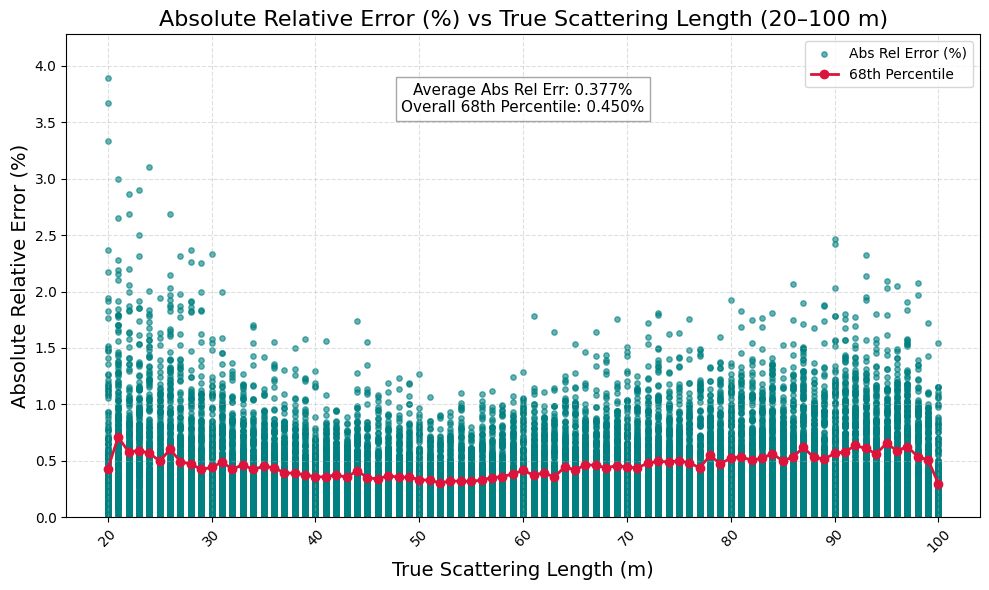

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# 가정: 아래 두 변수는 이미 계산되어 있습니다.
#
#    true_vals       # numpy array of shape (N,), 실제 Scattering Length (m) 값
#    abs_rel_errors  # numpy array of shape (N,), Absolute Relative Error (%) 값
# ─────────────────────────────────────────────────────────────────────────────

# 0) 0% 오차를 살짝 위로 띄우기 위한 작은 오프셋 ε 정의
epsilon = 1e-3  # 0.001% 만큼 살짝 위로 띄워줍니다.

# copy해서 0값에만 ε를 더해줍니다(원본 데이터는 그대로 둠)
abs_rel_plot = abs_rel_errors.copy()
abs_rel_plot[abs_rel_plot == 0] = epsilon

# 1) 20 m ~ 100 m 구간에 속하는 데이터만 선택 (필요시)
mask_range = (true_vals >= 20) & (true_vals <= 100)
true_in_range = true_vals[mask_range]
errs_in_range = abs_rel_plot[mask_range]

# 2) 고유한 True Scattering Length(범위 내) 구해서 정렬
unique_vals = np.unique(true_in_range)
# (만약 데이터가 정수 단위가 아니고, 특정 값만 있을 경우 그대로 사용)

# 3) 각 고유 값마다 68th percentile 계산
percentiles_68 = []
for val in unique_vals:
    submask = (true_in_range == val)
    if np.sum(submask) > 0:
        p68 = np.percentile(errs_in_range[submask], 68)
    else:
        p68 = np.nan
    percentiles_68.append(p68)
percentiles_68 = np.array(percentiles_68)

# 4) 전체 평균 및 전체 68th percentile (참고용)
avg_abs_rel_error = np.mean(abs_rel_errors[(true_vals >= 20) & (true_vals <= 100)])
overall_p68      = np.percentile(abs_rel_errors[(true_vals >= 20) & (true_vals <= 100)], 68)

# ─────────────────────────────────────────────────────────────────────────────
# 5) 그림 그리기
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 6))

# (A) Scatter: 모든 샘플 (20~100 m 범위) 그리기
plt.scatter(
    true_in_range,                      # x: True Scattering Length (20~100)
    errs_in_range,                      # y: 오프셋 적용된 Absolute Rel Error (%)
    color='teal', 
    s=15,                               # 점 크기
    alpha=0.6, 
    label='Abs Rel Error (%)'
)

# (B) 68th percentile 선 그리기
plt.plot(
    unique_vals, 
    percentiles_68, 
    color='crimson', 
    linewidth=2, 
    marker='o', 
    markersize=6, 
    label='68th Percentile'
)

# (C) x축 눈금: 20, 30, 40, …, 100
xticks = np.arange(20, 101, 10)
plt.xticks(xticks, rotation=45)

# (D) y축 레이블과 제목, 범례
plt.xlabel("True Scattering Length (m)", fontsize=14)
plt.ylabel("Absolute Relative Error (%)", fontsize=14)
plt.title("Absolute Relative Error (%) vs True Scattering Length (20–100 m)", fontsize=16)

# (E) 0% 에 오프셋을 준 점이 명확히 보이도록 y축 아래 여유를 약간 줌
y_min = 0  # 절대 최소값을 0으로 두고
y_max = np.nanmax(abs_rel_errors[(true_vals >= 20) & (true_vals <= 100)]) * 1.1
plt.ylim(0, y_max)

# (F) 전체 평균 및 전체 68th percentile 표시
mid_x = (20 + 100) / 2
plt.text(
    mid_x, 
    y_max * 0.9, 
    f"Average Abs Rel Err: {avg_abs_rel_error:.3f}%\n"
    f"Overall 68th Percentile: {overall_p68:.3f}%", 
    fontsize=11, 
    ha='center', 
    va='top', 
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray')
)

# (G) 보조격자 추가
plt.grid(True, linestyle='--', alpha=0.4)

plt.legend()
plt.tight_layout()
plt.show()


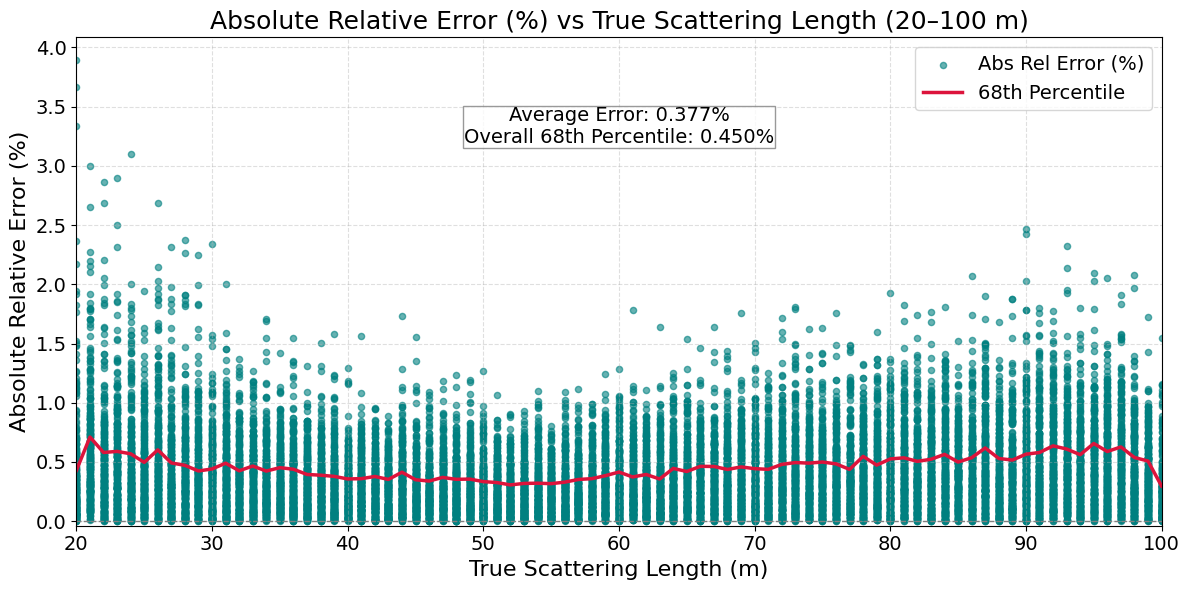

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# 가정: 아래 두 변수는 이미 정의되어 있습니다.
#    true_vals       : numpy array of shape (N,), 실제 Scattering Length (m)
#    abs_rel_errors  : numpy array of shape (N,), Absolute Relative Error (%) 
# ─────────────────────────────────────────────────────────────────────────────

# 1) 20 m ~ 100 m 범위 필터링
mask_range = (true_vals >= 20) & (true_vals <= 100)
true_in_range = true_vals[mask_range]
errs_in_range = abs_rel_errors[mask_range]

# 2) 0% 오차를 살짝 위로 띄우기 위한 작은 오프셋 ε 정의
epsilon = 1e-3  # 0.001% 만큼 위로 띄움
errs_plot = errs_in_range.copy()
errs_plot[errs_plot == 0] = epsilon

# 3) 고유한 True Scattering Length(범위 내) 구해서 정렬
unique_vals = np.unique(true_in_range)

# 4) 각 고유 값마다 68th percentile 계산
percentiles_68 = []
for val in unique_vals:
    submask = (true_in_range == val)
    if np.any(submask):
        p68 = np.percentile(errs_in_range[submask], 68)
    else:
        p68 = np.nan
    percentiles_68.append(p68)
percentiles_68 = np.array(percentiles_68)

# 5) 전체 범위의 최대 절대 상대 오차 구하기 (y 축 상한 설정에 사용)
y_max = np.nanmax(np.concatenate((errs_in_range, percentiles_68[~np.isnan(percentiles_68)])))

# 6) y축 하한을 작은 음수로 설정 (0%선이 x축 위로 살짝 올라오도록)
y_min = -0.01 * y_max

# 7) 전체 평균 및 전체 68th percentile 계산 (표시용)
avg_abs_rel_error = np.mean(errs_in_range)
overall_p68      = np.percentile(errs_in_range, 68)

# ─────────────────────────────────────────────────────────────────────────────
# 8) 그림 그리기: scatter + 68th percentile line, 글씨 키우고 레이아웃 조정
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 6))

# (A) Scatter: 모든 샘플 (20~100 m 범위) 그리기
plt.scatter(
    true_in_range,
    errs_plot,
    color='teal',
    s=20,
    alpha=0.6,
    label='Abs Rel Error (%)'
)

# (B) 68th percentile 선 그리기 (점 없이 선만)
plt.plot(
    unique_vals,
    percentiles_68,
    color='crimson',
    linewidth=2.5,
    label='68th Percentile'
)

# (C) x축을 20~100으로 딱 끝내기
plt.xlim(20, 100)

# (D) y축을 작은 음수부터 최대값의 약간 위까지
plt.ylim(y_min, y_max * 1.05)

# (E) 0% 선 강조 (연한 회색 점선)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# (F) 축 레이블 및 제목, 글씨 크기 키우기
plt.xlabel("True Scattering Length (m)", fontsize=16)
plt.ylabel("Absolute Relative Error (%)", fontsize=16)
plt.title("Absolute Relative Error (%) vs True Scattering Length (20–100 m)", fontsize=18)

# (G) x축 눈금: 20, 30, …, 100
xticks = np.arange(20, 101, 10)
plt.xticks(xticks, fontsize=14)

# (H) y축 눈금 크기 키우기
plt.yticks(fontsize=14)

# (I) 전체 평균 및 전체 68th percentile 표시 (글씨 크기 키움)
mid_x = (20 + 100) / 2
plt.text(
    mid_x,
    y_max * 0.9,
    f"Average Error: {avg_abs_rel_error:.3f}%\n"
    f"Overall 68th Percentile: {overall_p68:.3f}%",
    fontsize=14,
    ha='center',
    va='top',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', pad=0.6)
)

# (J) 보조격자 추가
plt.grid(True, linestyle='--', alpha=0.4)

# (K) 범례 (글씨 크기 키움)
plt.legend(fontsize=14, loc='upper right')

plt.tight_layout()
plt.show()


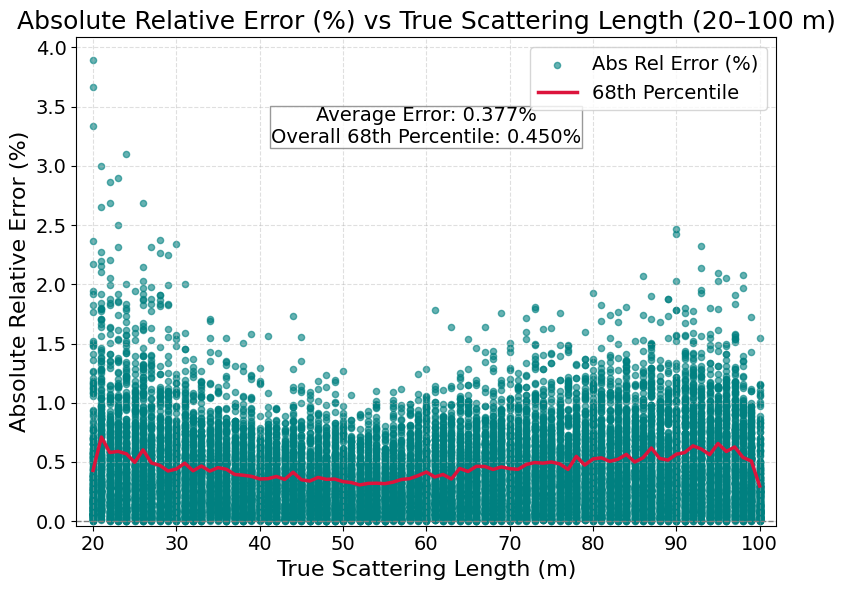

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# 가정: 아래 두 변수는 이미 정의되어 있습니다.
#    true_vals       : numpy array of shape (N,), 실제 Scattering Length (m)
#    abs_rel_errors  : numpy array of shape (N,), Absolute Relative Error (%) 
# ─────────────────────────────────────────────────────────────────────────────

# 1) 20 m ~ 100 m 범위 필터링
mask_range = (true_vals >= 20) & (true_vals <= 100)
true_in_range = true_vals[mask_range]
errs_in_range = abs_rel_errors[mask_range]

# 2) 0% 오차를 살짝 위로 띄우기 위한 작은 오프셋 ε 정의
epsilon = 1e-3  # 0.001% 만큼 위로 띄움
errs_plot = errs_in_range.copy()
errs_plot[errs_plot == 0] = epsilon

# 3) 고유한 True Scattering Length(범위 내) 구해서 정렬
unique_vals = np.unique(true_in_range)

# 4) 각 고유 값마다 68th percentile 계산
percentiles_68 = []
for val in unique_vals:
    submask = (true_in_range == val)
    if np.any(submask):
        p68 = np.percentile(errs_in_range[submask], 68)
    else:
        p68 = np.nan
    percentiles_68.append(p68)
percentiles_68 = np.array(percentiles_68)

# 5) 전체 범위의 최대 절대 상대 오차 구하기 (y 축 상한 설정에 사용)
y_max = np.nanmax(np.concatenate((errs_in_range, percentiles_68[~np.isnan(percentiles_68)])))

# 6) y축 하한을 작은 음수로 설정 (0%선이 x축 위로 살짝 올라오도록)
y_min = -0.01 * y_max

# 7) 전체 평균 및 전체 68th percentile 계산 (표시용)
avg_abs_rel_error = np.mean(errs_in_range)
overall_p68      = np.percentile(errs_in_range, 68)

# ─────────────────────────────────────────────────────────────────────────────
# 8) 그림 그리기: figsize=(8,6), x축에 여유 공간 추가
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(8, 6))

# (A) Scatter: 모든 샘플 (20~100 m 범위) 그리기
plt.scatter(
    true_in_range,
    errs_plot,
    color='teal',
    s=20,
    alpha=0.6,
    label='Abs Rel Error (%)'
)

# (B) 68th percentile 선 그리기 (점 없이 선만)
plt.plot(
    unique_vals,
    percentiles_68,
    color='crimson',
    linewidth=2.5,
    label='68th Percentile'
)

# (C) x축을 [18, 102] 정도로 여유 두고 설정
plt.xlim(18, 102)

# (D) y축을 작은 음수부터 최대값의 약간 위까지
plt.ylim(y_min, y_max * 1.05)

# (E) 0% 선 강조 (연한 회색 점선)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# (F) 축 레이블 및 제목, 글씨 크기 키우기
plt.xlabel("True Scattering Length (m)", fontsize=16)
plt.ylabel("Absolute Relative Error (%)", fontsize=16)
plt.title("Absolute Relative Error (%) vs True Scattering Length (20–100 m)", fontsize=18)

# (G) x축 눈금: 20, 30, …, 100
xticks = np.arange(20, 101, 10)
plt.xticks(xticks, fontsize=14)

# (H) y축 눈금 크기 키우기
plt.yticks(fontsize=14)

# (I) 전체 평균 및 전체 68th percentile 표시 (글씨 크기 키움)
mid_x = (18 + 102) / 2
plt.text(
    mid_x,
    y_max * 0.9,
    f"Average Error: {avg_abs_rel_error:.3f}%\n"
    f"Overall 68th Percentile: {overall_p68:.3f}%",
    fontsize=14,
    ha='center',
    va='top',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', pad=0.6)
)

# (J) 보조격자 추가
plt.grid(True, linestyle='--', alpha=0.4)

# (K) 범례 (글씨 크기 키움)
plt.legend(fontsize=14, loc='upper right')

plt.tight_layout()
plt.show()


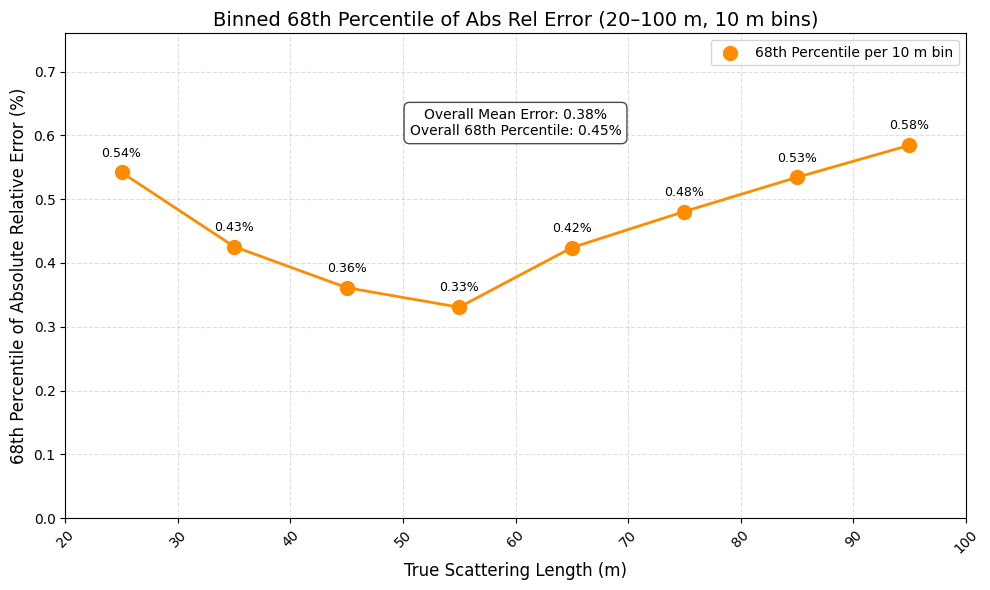

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────
# 가정: 이미 계산된 true_vals, abs_rel_errors가 있고,
#       둘 다 numpy array 형태입니다.
# true_vals       # (N,) 실제 scattering 길이 (m)
# abs_rel_errors  # (N,) 절대 상대 오차 (%)
# ─────────────────────────────────────────────────────────────

# 1) 20 m부터 100 m까지 10 m 간격으로 bin 경계 정의
bin_edges   = np.arange(20, 100 + 10, 10)         
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # [25, 35, …, 95]

# 2) 각 bin 구간에서 68번째 백분위 계산
percentiles_68 = []
for i in range(len(bin_edges) - 1):
    low, high = bin_edges[i], bin_edges[i + 1]
    mask = (true_vals >= low) & (true_vals < high)
    if np.any(mask):
        p68 = np.percentile(abs_rel_errors[mask], 68)
    else:
        p68 = np.nan
    percentiles_68.append(p68)
percentiles_68 = np.array(percentiles_68)

# 3) (옵션) 전체 평균 및 전체 68번째 백분위 (표시용)
avg_abs_rel_error = np.mean(abs_rel_errors)
overall_p68      = np.percentile(abs_rel_errors, 68)

# ─────────────────────────────────────────────────────────────
# 4) 그래프 그리기: 오직 bin_centers vs percentiles_68
# ─────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 6))

# (A) 10 m 단위 비닝 구간 중앙에서 68번째 백분위 점 (색: darkorange)
plt.scatter(bin_centers, percentiles_68,
            color='darkorange', s=100, marker='o',
            label='68th Percentile per 10 m bin')

# (B) 해당 점들을 선으로 연결
plt.plot(bin_centers, percentiles_68,
         color='darkorange', linewidth=2)

# (C) 각 점 위에 퍼센트 값 텍스트로 표시
for x, y in zip(bin_centers, percentiles_68):
    if not np.isnan(y):
        plt.text(x, y + 0.02, f"{y:.2f}%",
                 ha='center', va='bottom', fontsize=9)

# (D) (옵션) 전체 평균 & 전체 68번째 백분위 텍스트
mid_x = (bin_centers[0] + bin_centers[-1]) / 2
plt.text(mid_x, np.nanmax(percentiles_68) * 1.1,
         f"Overall Mean Error: {avg_abs_rel_error:.2f}%\n"
         f"Overall 68th Percentile: {overall_p68:.2f}%",
         ha='center', va='top',
         fontsize=10,
         bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.7))

# (E) 축 레이블 및 제목
plt.xlabel("True Scattering Length (m)", fontsize=12)
plt.ylabel("68th Percentile of Absolute Relative Error (%)", fontsize=12)
plt.title("Binned 68th Percentile of Abs Rel Error (20–100 m, 10 m bins)", fontsize=14)

# (F) x축 눈금: 20, 30, 40, …, 100
plt.xticks(bin_edges, rotation=45)

# (G) y축 범위 조금 여유 있게 설정
ymax = np.nanmax(percentiles_68) * 1.3
plt.ylim(0, ymax if not np.isnan(ymax) else 1.0)

# (H) 격자 추가 및 범례
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(frameon=True)

plt.tight_layout()
plt.show()


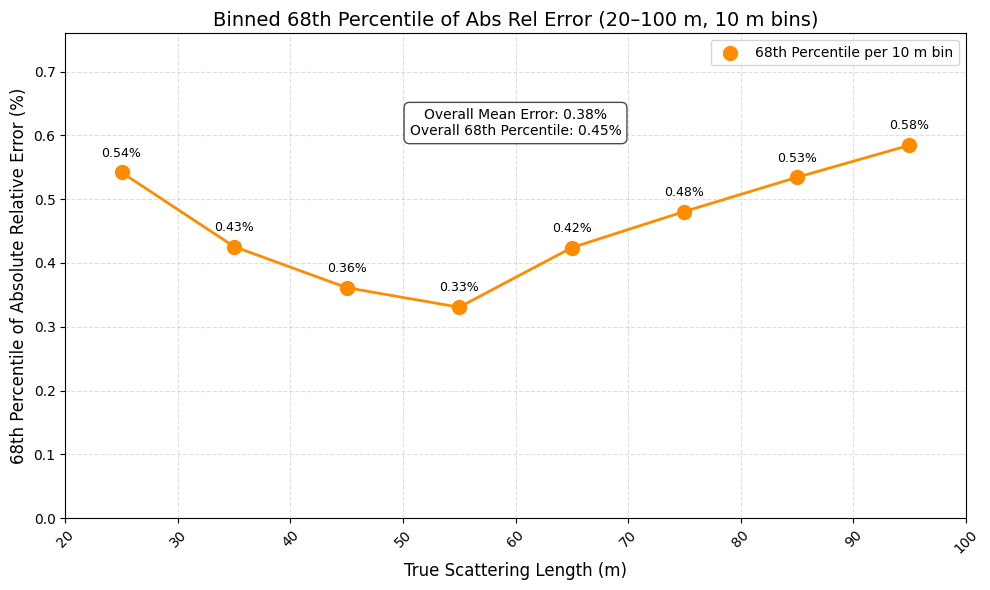

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────
# 가정: 이미 계산된 true_vals, abs_rel_errors가 있고,
#       둘 다 numpy array 형태입니다.
# true_vals       # (N,) 실제 scattering 길이 (m)
# abs_rel_errors  # (N,) 절대 상대 오차 (%)
# ─────────────────────────────────────────────────────────────

# 1) 20 m부터 100 m까지 10 m 간격으로 bin 경계 정의
bin_edges   = np.arange(20, 100 + 10, 10)         
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # [25, 35, …, 95]

# 2) 각 bin 구간에서 68번째 백분위 계산
percentiles_68 = []
for i in range(len(bin_edges) - 1):
    low, high = bin_edges[i], bin_edges[i + 1]
    mask = (true_vals >= low) & (true_vals < high)
    if np.any(mask):
        p68 = np.percentile(abs_rel_errors[mask], 68)
    else:
        p68 = np.nan
    percentiles_68.append(p68)
percentiles_68 = np.array(percentiles_68)

# 3) (옵션) 전체 평균 및 전체 68번째 백분위 (표시용)
avg_abs_rel_error = np.mean(abs_rel_errors)
overall_p68      = np.percentile(abs_rel_errors, 68)

# ─────────────────────────────────────────────────────────────
# 4) 그래프 그리기: 오직 bin_centers vs percentiles_68
# ─────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 6))

# (A) 10 m 단위 비닝 구간 중앙에서 68번째 백분위 점 (색: darkorange)
plt.scatter(bin_centers, percentiles_68,
            color='darkorange', s=100, marker='o',
            label='68th Percentile per 10 m bin')

# (B) 해당 점들을 선으로 연결
plt.plot(bin_centers, percentiles_68,
         color='darkorange', linewidth=2)

# (C) 각 점 위에 퍼센트 값 텍스트로 표시
for x, y in zip(bin_centers, percentiles_68):
    if not np.isnan(y):
        plt.text(x, y + 0.02, f"{y:.2f}%",
                 ha='center', va='bottom', fontsize=9)

# (D) (옵션) 전체 평균 & 전체 68번째 백분위 텍스트
mid_x = (bin_centers[0] + bin_centers[-1]) / 2
plt.text(mid_x, np.nanmax(percentiles_68) * 1.1,
         f"Overall Mean Error: {avg_abs_rel_error:.2f}%\n"
         f"Overall 68th Percentile: {overall_p68:.2f}%",
         ha='center', va='top',
         fontsize=10,
         bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.7))

# (E) 축 레이블 및 제목
plt.xlabel("True Scattering Length (m)", fontsize=12)
plt.ylabel("68th Percentile of Absolute Relative Error (%)", fontsize=12)
plt.title("Binned 68th Percentile of Abs Rel Error (20–100 m, 10 m bins)", fontsize=14)

# (F) x축 눈금: 20, 30, 40, …, 100
plt.xticks(bin_edges, rotation=45)

# (G) y축 범위 조금 여유 있게 설정
ymax = np.nanmax(percentiles_68) * 1.3
plt.ylim(0, ymax if not np.isnan(ymax) else 1.0)

# (H) 격자 추가 및 범례
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(frameon=True)

plt.tight_layout()
plt.show()


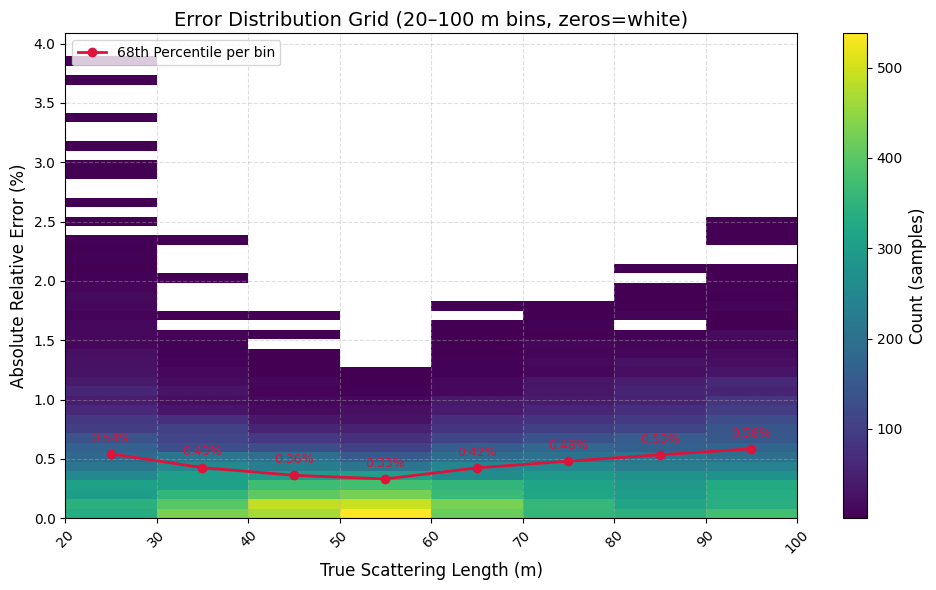

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# 가정: 이미 계산된 변수 true_vals, abs_rel_errors가 numpy array로 정의되어 있습니다.
# ─────────────────────────────────────────────────────────────────────────────

# 1) X축(Scattering 길이) bin 경계: 20 m부터 100 m까지 10m 간격
x_edges = np.arange(20, 100 + 10, 10)  # [20, 30, 40, …, 100]

# 2) Y축(Abs Rel Error) bin 경계: 0%부터 최대 에러까지 50개 구간 예시
y_max = np.nanmax(abs_rel_errors)
y_edges = np.linspace(0.0, y_max, 50)

# 3) 2D 히스토그램 계산
hist, _, _ = np.histogram2d(
    true_vals,
    abs_rel_errors,
    bins=[x_edges, y_edges]
)

# 4) 히스토그램에서 0 값을 마스크 처리
hist_masked = np.ma.masked_where(hist == 0, hist)

# 5) 각 X-bin에서 68번째 백분위 계산 (원하는 선/점으로 덧그리기)
bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
percentiles_68 = []
for i in range(len(x_edges) - 1):
    low, high = x_edges[i], x_edges[i + 1]
    mask = (true_vals >= low) & (true_vals < high)
    if np.any(mask):
        p68 = np.percentile(abs_rel_errors[mask], 68)
    else:
        p68 = np.nan
    percentiles_68.append(p68)
percentiles_68 = np.array(percentiles_68)

# ─────────────────────────────────────────────────────────────────────────────
# 6) 플롯: heatmap + 68번째 백분위 선
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 6))

# (A) colormap 준비: 'viridis'를 사용하되, 마스크된(0값) 구간은 흰색으로 표시
cmap = plt.get_cmap('viridis')
cmap.set_bad('white')  # 마스크된 부분(bad data)을 흰색으로

# (B) 격자 좌표 만들기
X, Y = np.meshgrid(x_edges, y_edges)

# (C) pcolormesh로 히스토그램 그리기 (hist_masked.T 사용!)
mesh = plt.pcolormesh(
    X, Y,
    hist_masked.T,   # shape = (len(y_edges)-1, len(x_edges)-1)
    cmap=cmap,
    shading='auto'
)

# (D) 컬러바 (샘플 개수)
cbar = plt.colorbar(mesh)
cbar.set_label("Count (samples)", fontsize=12)

# (E) 68번째 백분위 선과 점 그리기 (색: crimson)
plt.plot(
    bin_centers, percentiles_68,
    color='crimson', lw=2, marker='o',
    label='68th Percentile per bin'
)

# (F) 각 점 위에 퍼센트 값 텍스트 표시
for xcen, p68 in zip(bin_centers, percentiles_68):
    if not np.isnan(p68):
        plt.text(
            xcen, p68 + y_max * 0.02,  # 약간 위로 오프셋
            f"{p68:.2f}%",
            ha='center', va='bottom',
            fontsize=9, color='crimson'
        )

# (G) 축 레이블 및 제목
plt.xlabel("True Scattering Length (m)", fontsize=12)
plt.ylabel("Absolute Relative Error (%)", fontsize=12)
plt.title("Error Distribution Grid (20–100 m bins, zeros=white)", fontsize=14)

# (H) X축 눈금: 20, 30, …, 100
plt.xticks(x_edges, rotation=45)

# (I) Y축 범위: 0 ~ y_max*1.05 (조금 여유 있게)
plt.ylim(0, y_max * 1.05)

# (J) 격자 보조선
plt.grid(linestyle='--', alpha=0.4)

# (K) 범례
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


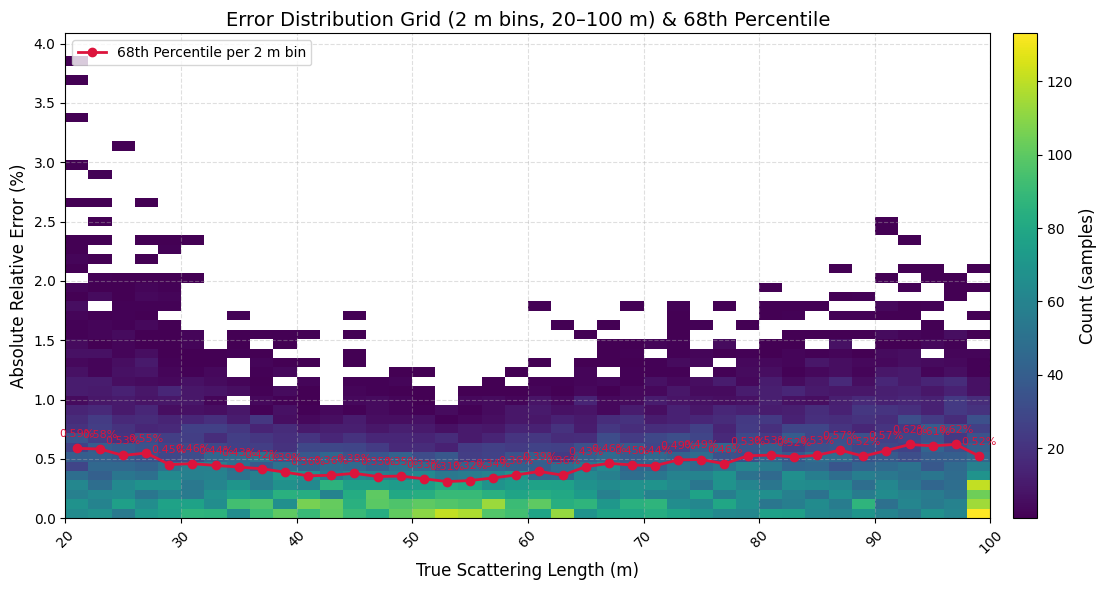

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# 가정: 이미 계산된 변수 true_vals, abs_rel_errors가 numpy array로 정의되어 있습니다.
#   - true_vals      : shape (N,), 실제 Scattering Length (m)
#   - abs_rel_errors : shape (N,), Absolute Relative Error (%)
# ─────────────────────────────────────────────────────────────────────────────

# 1) X축 bin 경계: 20 m부터 100 m까지 2 m 간격
x_edges = np.arange(20, 100 + 2, 2)  # [20, 22, 24, …, 100]

# 2) Y축 bin 경계: 0%부터 최대 에러까지, 예시로 50개 구간
#    (필요에 따라 bin 개수/간격을 변경하세요)
y_max = np.nanmax(abs_rel_errors)
y_edges = np.linspace(0.0, y_max, 50)

# 3) 2D 히스토그램 계산
hist, x_edges_out, y_edges_out = np.histogram2d(
    true_vals,
    abs_rel_errors,
    bins=[x_edges, y_edges]
)

# 4) 히스토그램에서 0값(빈 칸)을 마스크 처리
hist_masked = np.ma.masked_where(hist == 0, hist)

# 5) 각 X-bin(2 m 구간)에서 68번째 백분위 계산
#    bin_centers_2m는 [21, 23, 25, …, 99] 형태가 됩니다.
bin_centers_2m = (x_edges[:-1] + x_edges[1:]) / 2
percentiles_68 = []
for i in range(len(x_edges) - 1):
    low, high = x_edges[i], x_edges[i + 1]
    mask = (true_vals >= low) & (true_vals < high)
    if np.any(mask):
        p68 = np.percentile(abs_rel_errors[mask], 68)
    else:
        p68 = np.nan
    percentiles_68.append(p68)
percentiles_68 = np.array(percentiles_68)

# ─────────────────────────────────────────────────────────────────────────────
# 6) 플롯: 2D 그리드(heatmap) + 68번째 백분위 선
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 6))

# (A) colormap 준비: viridis 사용, 빈 칸(마스크된 부분)은 흰색
cmap = plt.get_cmap('viridis')
cmap.set_bad('white')

# (B) 격자 좌표 생성
X, Y = np.meshgrid(x_edges, y_edges)

# (C) pcolormesh로 히스토그램(heatmap) 그리기
mesh = plt.pcolormesh(
    X, Y,
    hist_masked.T,  # shape = (len(y_edges)-1, len(x_edges)-1)
    cmap=cmap,
    shading='auto'
)

# (D) 컬러바: 샘플 개수
cbar = plt.colorbar(mesh, pad=0.02)
cbar.ax.set_ylabel("Count (samples)", fontsize=12)

# (E) 68번째 백분위 선과 점 그리기 (색: crimson)
plt.plot(
    bin_centers_2m, percentiles_68,
    color='crimson', lw=2, marker='o',
    label='68th Percentile per 2 m bin'
)

# (F) 각 점 위에 퍼센트 값 텍스트 표시
for xcen, p68 in zip(bin_centers_2m, percentiles_68):
    if not np.isnan(p68):
        plt.text(
            xcen, p68 + y_max * 0.02,  # y축 위쪽으로 약간 오프셋
            f"{p68:.2f}%",
            ha='center', va='bottom',
            fontsize=8, color='crimson'
        )

# (G) 축 레이블 및 제목
plt.xlabel("True Scattering Length (m)", fontsize=12)
plt.ylabel("Absolute Relative Error (%)", fontsize=12)
plt.title("Error Distribution Grid (2 m bins, 20–100 m) & 68th Percentile", fontsize=14)

# (H) x축 눈금: 20, 30, 40, …, 100 (원하시면 2 m 간격으로도 가능)
xticks = np.arange(20, 101, 10)  # 10 m 단위로 눈금 표시
plt.xticks(xticks, rotation=45)

# (I) y축 범위: 0 ~ y_max * 1.05 (약간 여유 있게)
plt.ylim(0, y_max * 1.05)

# (J) 보조격자(그리드)
plt.grid(linestyle='--', alpha=0.4)

# (K) 범례
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [24]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ─────────────────────────────────────────────────────────────────────────────
# 1) 이전에 정의한 ViT50_3block 모델, optimizer, scheduler와 동일하게 설정
# ─────────────────────────────────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# (A) 모델 정의
model = ViT50_3block(
    img_size=300,
    patch_size=30,
    embed_dim=64,
    depth=4,
    num_heads=4,
    mlp_dim=256,
    num_classes=1
).to(device)
# (B) Optimizer + Scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    verbose=True
)

criterion = nn.MSELoss()

# ─────────────────────────────────────────────────────────────────────────────
# 2) 체크포인트 로드
#    (train_validate 함수에서 저장한 best 모델 파일을 지정)
# ─────────────────────────────────────────────────────────────────────────────
best_model_path = '/home/work/CamSim/Deep-Learning/best_vit50_3block_bulk_0_270.pth'
checkpoint = torch.load(best_model_path, map_location=device)

# 체크포인트가 딕셔너리 형태인지(state dict만인지) 확인
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    # {'model_state_dict': ..., 'optimizer_state_dict': ..., 'val_loss': ..., ...} 형태
    model.load_state_dict(checkpoint['model_state_dict'])
    if 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint.get('epoch', 0) + 1
    best_val_loss = checkpoint.get('val_loss', float('inf'))
    print(f"Loaded checkpoint from epoch {checkpoint.get('epoch', 0)}. Continuing from epoch {start_epoch}.")
else:
    # 단순히 model.state_dict()만 저장된 경우
    model.load_state_dict(checkpoint)
    start_epoch = 1
    best_val_loss = float('inf')
    print("Loaded state_dict-only checkpoint. Starting from epoch 1.")

# ─────────────────────────────────────────────────────────────────────────────
# 3) 학습을 이어갈 에폭 수 및 Early Stopping 변수
# ─────────────────────────────────────────────────────────────────────────────
additional_epochs = 50
total_epochs = start_epoch + additional_epochs - 1
patience = 10
wait = 0

# ─────────────────────────────────────────────────────────────────────────────
# 4) 학습 재개 루프
# ─────────────────────────────────────────────────────────────────────────────
for epoch in range(start_epoch, total_epochs + 1):
    # ---- Training ----
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)   # (B, 1, 500, 500)
        labels = labels.to(device)   # (B,)

        optimizer.zero_grad()
        outputs = model(images)      # (B,)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)

    # ---- Validation ----
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

    train_loss = running_train_loss / len(train_loader.dataset)
    val_loss   = running_val_loss   / len(val_loader.dataset)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"[Epoch {epoch}/{total_epochs}] Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {current_lr:.6g}")

    # ---- ReduceLROnPlateau 스케줄러 업데이트 ----
    scheduler.step(val_loss)

    # ---- Early Stopping 및 체크포인트 갱신 ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, best_model_path)
        print(f"  → Improved val loss. Checkpoint updated at epoch {epoch}.")
    else:
        wait += 1
        if wait >= patience:
            print(f"  → Early stopping at epoch {epoch}.")
            break

# ─────────────────────────────────────────────────────────────────────────────
# 5) 최종 모델 저장
# ─────────────────────────────────────────────────────────────────────────────
final_save_path = best_model_path.replace('.pth', '_finetune_final.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss
}, final_save_path)
print(f"Final model saved to: {final_save_path}")


Loaded state_dict-only checkpoint. Starting from epoch 1.


/tmp/ipykernel_12703/3320611599.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device)


[Epoch 1/50] Train Loss: 0.000069 | Val Loss: 0.000067 | LR: 1e-05
  → Improved val loss. Checkpoint updated at epoch 1.
[Epoch 2/50] Train Loss: 0.000069 | Val Loss: 0.000065 | LR: 1e-05
  → Improved val loss. Checkpoint updated at epoch 2.
[Epoch 3/50] Train Loss: 0.000068 | Val Loss: 0.000066 | LR: 1e-05
[Epoch 4/50] Train Loss: 0.000068 | Val Loss: 0.000064 | LR: 1e-05
  → Improved val loss. Checkpoint updated at epoch 4.
[Epoch 5/50] Train Loss: 0.000068 | Val Loss: 0.000065 | LR: 1e-05
[Epoch 6/50] Train Loss: 0.000068 | Val Loss: 0.000066 | LR: 1e-05
[Epoch 7/50] Train Loss: 0.000068 | Val Loss: 0.000067 | LR: 1e-05
[Epoch 8/50] Train Loss: 0.000066 | Val Loss: 0.000064 | LR: 5e-06
  → Improved val loss. Checkpoint updated at epoch 8.
[Epoch 9/50] Train Loss: 0.000066 | Val Loss: 0.000064 | LR: 5e-06
  → Improved val loss. Checkpoint updated at epoch 9.
[Epoch 10/50] Train Loss: 0.000066 | Val Loss: 0.000064 | LR: 5e-06
[Epoch 11/50] Train Loss: 0.000066 | Val Loss: 0.000064 | L

/tmp/ipykernel_12703/220042027.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device)
/tmp/ipykernel_12703/2200420

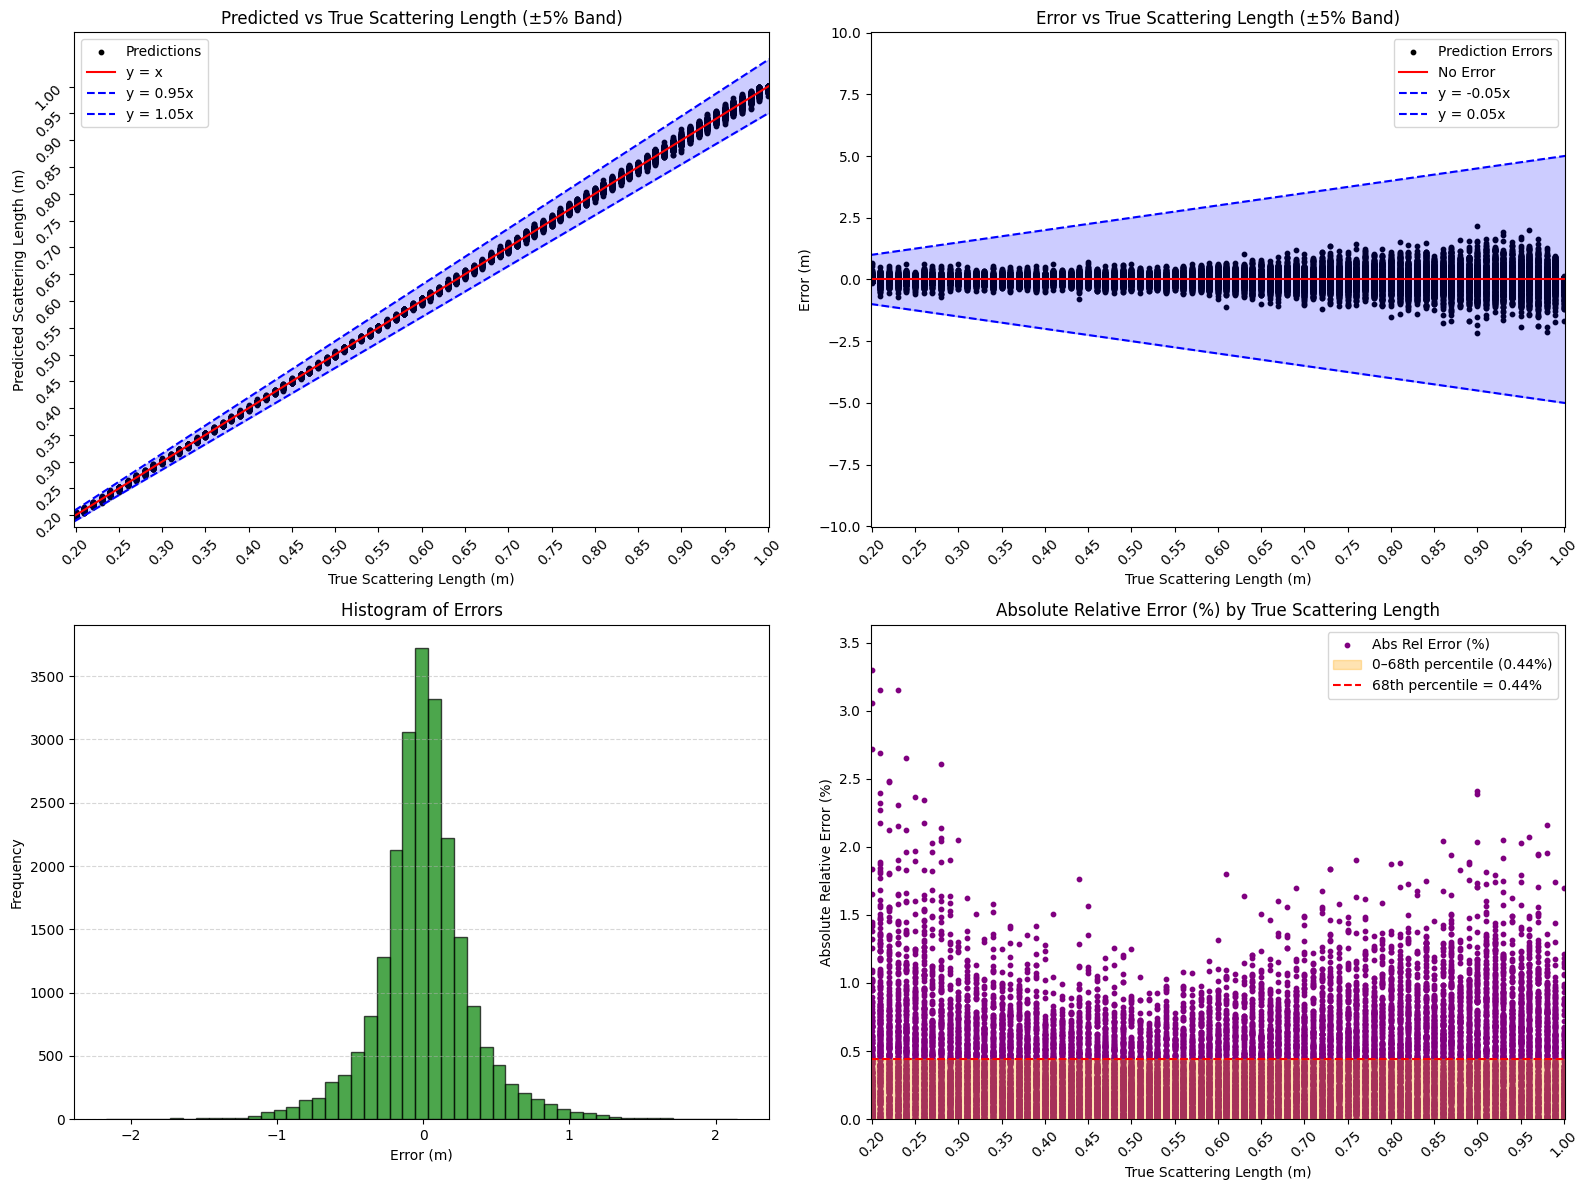

In [25]:
best_model_path = "/home/work/CamSim/Deep-Learning/best_vit50_3block_bulk_0_270_finetune_final.pth"
# 1) 체크포인트 불러오기
checkpoint = torch.load(best_model_path, map_location=device)

checkpoint = torch.load(best_model_path, map_location=device)

# 저장할 때 'model_state_dict'라는 키 없이 model.state_dict()만 저장한 경우라면
# model.load_state_dict(checkpoint)

# model.eval()


# 2) model_state_dict만 꺼내서 로드
model.load_state_dict(checkpoint['model_state_dict'])

# (선택) optimizer, scheduler 상태도 복원하고 싶다면 아래처럼 해 주세요.
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

model.eval()

true_vals = []
pred_vals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)   # (B, 1, 500, 500)
        labels = labels.to(device)   # (B,)
        outputs = model(images)      # (B,)

        # 정규화 복원 → 원래 스케일로
        labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
        preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

        true_vals.extend(labels_orig.tolist())
        pred_vals.extend(preds_orig.tolist())

true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)
errors = pred_vals - true_vals
abs_rel_errors = np.abs(errors / true_vals) * 100.0

# (G) 결과 시각화
# (G) 결과 시각화
plt.figure(figsize=(16, 12))
mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())
unique_true_labels = np.unique(true_vals)

# “뛰엄뛰엄” 표시를 위한 인덱스 계산 (5개 간격)
tick_idx = np.arange(0, len(unique_true_labels), 5)
xticks_cm = unique_true_labels[tick_idx]

# 1) Predicted vs True with ±5% Band
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx],
                 [0.95*mn, 0.95*mx],
                 [1.05*mn, 1.05*mx],
                 color='blue', alpha=0.2)

# x축 눈금을 “뛰엄뛰엄(5개 간격)”으로 설정
ax1.set_xticks(xticks_cm)
ax1.set_xticklabels([f"{val/100:.2f}" for val in xticks_cm], rotation=45)
# y축도 동일하게 (원한다면)
ax1.set_yticks(xticks_cm)
ax1.set_yticklabels([f"{val/100:.2f}" for val in xticks_cm], rotation=45)

ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (m)")
ax1.set_ylabel("Predicted Scattering Length (m)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()

# 2) Error vs True with ±5% Band
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx],
                 [-0.05*mn, -0.05*mx],
                 [0.05*mn, 0.05*mx],
                 color='blue', alpha=0.2)

ax2.set_xticks(xticks_cm)
ax2.set_xticklabels([f"{val/100:.2f}" for val in xticks_cm], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (m)")
ax2.set_ylabel("Error (m)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()

# 3) Histogram of Errors (50 bins)
ax3 = plt.subplot(2, 2, 3)
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (m)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# 4) Absolute Relative Error (%) by True with 68th Percentile
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
perc68 = np.percentile(abs_rel_errors, 68)
ax4.fill_between([mn, mx],
                 0, perc68,
                 color='orange', alpha=0.3,
                 label=f'0–68th percentile ({perc68:.2f}%)')
ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
           label=f'68th percentile = {perc68:.2f}%')

ax4.set_xticks(xticks_cm)
ax4.set_xticklabels([f"{val/100:.2f}" for val in xticks_cm], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (m)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
ax4.legend()

plt.tight_layout()
plt.show()

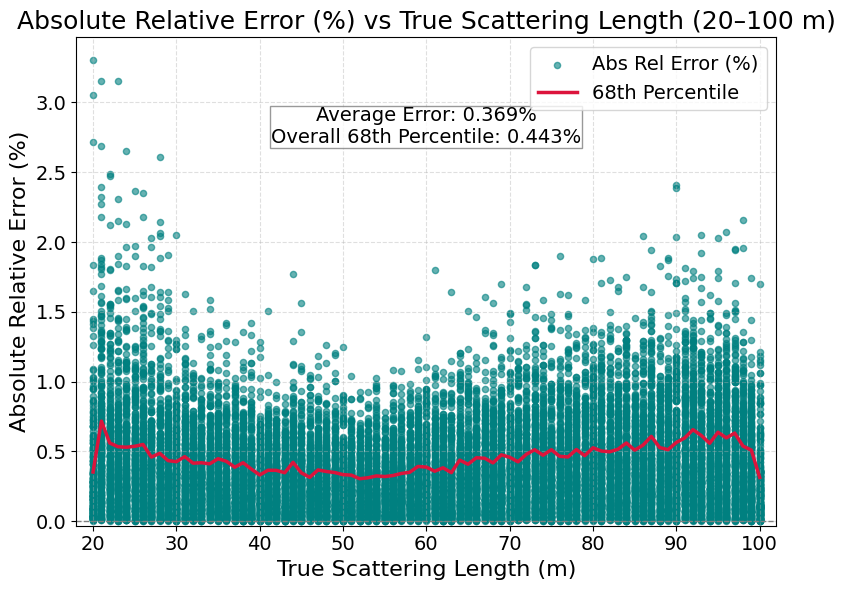

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# 가정: 아래 두 변수는 이미 정의되어 있습니다.
#    true_vals       : numpy array of shape (N,), 실제 Scattering Length (m)
#    abs_rel_errors  : numpy array of shape (N,), Absolute Relative Error (%) 
# ─────────────────────────────────────────────────────────────────────────────

# 1) 20 m ~ 100 m 범위 필터링
mask_range = (true_vals >= 20) & (true_vals <= 100)
true_in_range = true_vals[mask_range]
errs_in_range = abs_rel_errors[mask_range]

# 2) 0% 오차를 살짝 위로 띄우기 위한 작은 오프셋 ε 정의
epsilon = 1e-3  # 0.001% 만큼 위로 띄움
errs_plot = errs_in_range.copy()
errs_plot[errs_plot == 0] = epsilon

# 3) 고유한 True Scattering Length(범위 내) 구해서 정렬
unique_vals = np.unique(true_in_range)

# 4) 각 고유 값마다 68th percentile 계산
percentiles_68 = []
for val in unique_vals:
    submask = (true_in_range == val)
    if np.any(submask):
        p68 = np.percentile(errs_in_range[submask], 68)
    else:
        p68 = np.nan
    percentiles_68.append(p68)
percentiles_68 = np.array(percentiles_68)

# 5) 전체 범위의 최대 절대 상대 오차 구하기 (y 축 상한 설정에 사용)
y_max = np.nanmax(np.concatenate((errs_in_range, percentiles_68[~np.isnan(percentiles_68)])))

# 6) y축 하한을 작은 음수로 설정 (0%선이 x축 위로 살짝 올라오도록)
y_min = -0.01 * y_max

# 7) 전체 평균 및 전체 68th percentile 계산 (표시용)
avg_abs_rel_error = np.mean(errs_in_range)
overall_p68      = np.percentile(errs_in_range, 68)

# ─────────────────────────────────────────────────────────────────────────────
# 8) 그림 그리기: figsize=(8,6), x축에 여유 공간 추가
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(8, 6))

# (A) Scatter: 모든 샘플 (20~100 m 범위) 그리기
plt.scatter(
    true_in_range,
    errs_plot,
    color='teal',
    s=20,
    alpha=0.6,
    label='Abs Rel Error (%)'
)

# (B) 68th percentile 선 그리기 (점 없이 선만)
plt.plot(
    unique_vals,
    percentiles_68,
    color='crimson',
    linewidth=2.5,
    label='68th Percentile'
)

# (C) x축을 [18, 102] 정도로 여유 두고 설정
plt.xlim(18, 102)

# (D) y축을 작은 음수부터 최대값의 약간 위까지
plt.ylim(y_min, y_max * 1.05)

# (E) 0% 선 강조 (연한 회색 점선)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# (F) 축 레이블 및 제목, 글씨 크기 키우기
plt.xlabel("True Scattering Length (m)", fontsize=16)
plt.ylabel("Absolute Relative Error (%)", fontsize=16)
plt.title("Absolute Relative Error (%) vs True Scattering Length (20–100 m)", fontsize=18)

# (G) x축 눈금: 20, 30, …, 100
xticks = np.arange(20, 101, 10)
plt.xticks(xticks, fontsize=14)

# (H) y축 눈금 크기 키우기
plt.yticks(fontsize=14)

# (I) 전체 평균 및 전체 68th percentile 표시 (글씨 크기 키움)
mid_x = (18 + 102) / 2
plt.text(
    mid_x,
    y_max * 0.9,
    f"Average Error: {avg_abs_rel_error:.3f}%\n"
    f"Overall 68th Percentile: {overall_p68:.3f}%",
    fontsize=14,
    ha='center',
    va='top',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', pad=0.6)
)

# (J) 보조격자 추가
plt.grid(True, linestyle='--', alpha=0.4)

# (K) 범례 (글씨 크기 키움)
plt.legend(fontsize=14, loc='upper right')

plt.tight_layout()
plt.show()

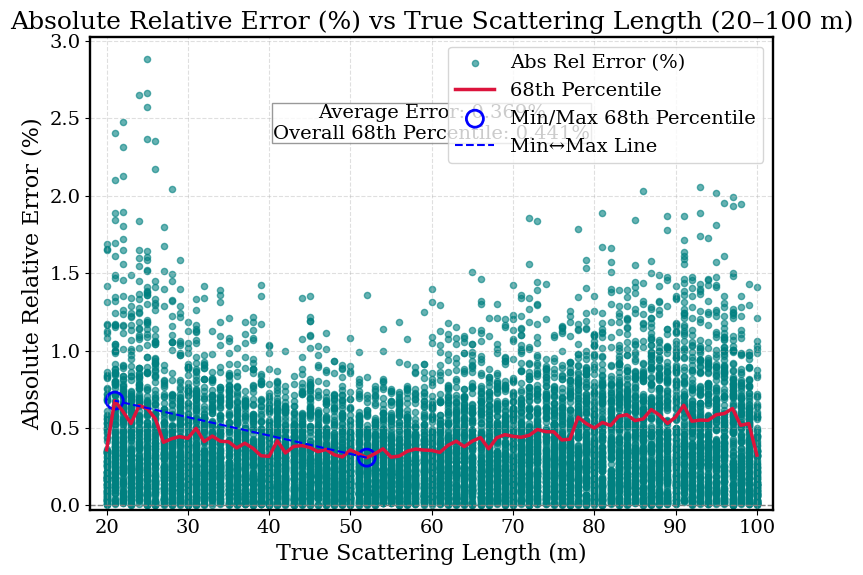

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# 가정: 아래 두 변수는 이미 정의되어 있습니다.
#    true_vals       : numpy array of shape (N,), 실제 Scattering Length (m)
#    abs_rel_errors  : numpy array of shape (N,), Absolute Relative Error (%) 
# ─────────────────────────────────────────────────────────────────────────────

# 1) 20 m ~ 100 m 범위 필터링
mask_range = (true_vals >= 20) & (true_vals <= 100)
true_in_range = true_vals[mask_range]
errs_in_range = abs_rel_errors[mask_range]

# 2) 0% 오차를 살짝 위로 띄우기 위한 작은 오프셋 ε 정의
epsilon = 1e-3  # 0.001% 만큼 위로 띄움
errs_plot = errs_in_range.copy()
errs_plot[errs_plot == 0] = epsilon

# 3) 고유한 True Scattering Length(범위 내) 구해서 정렬
unique_vals = np.unique(true_in_range)

# 4) 각 고유 값마다 68th percentile 계산
percentiles_68 = []
for val in unique_vals:
    submask = (true_in_range == val)
    if np.any(submask):
        p68 = np.percentile(errs_in_range[submask], 68)
    else:
        p68 = np.nan
    percentiles_68.append(p68)
percentiles_68 = np.array(percentiles_68)

# 5) 전체 범위의 최대 절대 상대 오차 구하기 (y 축 상한 설정에 사용)
y_max = np.nanmax(np.concatenate((errs_in_range, percentiles_68[~np.isnan(percentiles_68)])))

# 6) y축 하한을 작은 음수로 설정 (0%선이 x축 위로 살짝 올라오도록)
y_min = -0.01 * y_max

# 7) 전체 평균 및 전체 68th percentile 계산 (표시용)
avg_abs_rel_error = np.mean(errs_in_range)
overall_p68      = np.percentile(errs_in_range, 68)

# ─────────────────────────────────────────────────────────────────────────────
# 8) 그림 그리기: figsize=(8,6), x축에 여유 공간 추가
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(8, 6))

# (A) Scatter: 모든 샘플 (20~100 m 범위) 그리기
plt.scatter(
    true_in_range,
    errs_plot,
    color='teal',
    s=20,
    alpha=0.6,
    label='Abs Rel Error (%)'
)

# (B) 68th percentile 선 그리기 (점없이 선만)
plt.plot(
    unique_vals,
    percentiles_68,
    color='crimson',
    linewidth=2.5,
    label='68th Percentile'
)

# (C) 최대/최소 68th percentile 값 찾기
valid_mask = ~np.isnan(percentiles_68)
vals = percentiles_68[valid_mask]
xs = unique_vals[valid_mask]
idx_min = np.argmin(vals)
idx_max = np.argmax(vals)
x_min, y_min_val = xs[idx_min], vals[idx_min]
x_max, y_max_val = xs[idx_max], vals[idx_max]

# (D) 최대/최소 지점 동그라미로 강조 (파란 테두리, 투명 내부)
plt.scatter(
    [x_min, x_max],
    [y_min_val, y_max_val],
    facecolors='none',
    edgecolors='blue',
    s=150,
    linewidths=2,
    label='Min/Max 68th Percentile'
)

# (E) 최대/최소 지점 연결선 그리기 (파란 점선)
plt.plot(
    [x_min, x_max],
    [y_min_val, y_max_val],
    color='blue',
    linestyle='--',
    linewidth=1.5,
    label='Min↔Max Line'
)

# (F) x축을 [18, 102] 정도로 여유 두고 설정
plt.xlim(18, 102)

# (G) y축을 작은 음수부터 최대값의 약간 위까지
plt.ylim(y_min, y_max * 1.05)

# (H) 0% 선 강조 (연한 회색 점선)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# (I) 축 레이블 및 제목, 글씨 크기 키우기
plt.xlabel("True Scattering Length (m)", fontsize=16)
plt.ylabel("Absolute Relative Error (%)", fontsize=16)
plt.title("Absolute Relative Error (%) vs True Scattering Length (20–100 m)", fontsize=18)

# (J) x축 눈금: 20, 30, …, 100
xticks = np.arange(20, 101, 10)
plt.xticks(xticks, fontsize=14)

# (K) y축 눈금 크기 키우기
plt.yticks(fontsize=14)

# (L) 전체 평균 및 전체 68th percentile 표시 (글씨 크기 키움)
mid_x = (18 + 102) / 2
plt.text(
    mid_x,
    y_max * 0.9,
    f"Average Error: {avg_abs_rel_error:.3f}%\n"
    f"Overall 68th Percentile: {overall_p68:.3f}%",
    fontsize=14,
    ha='center',
    va='top',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', pad=0.6)
)

# (M) 보조격자 추가
plt.grid(True, linestyle='--', alpha=0.4)

# (N) 범례 (글씨 크기 키움)
plt.legend(fontsize=14, loc='upper right')

plt.tight_layout()
plt.show()

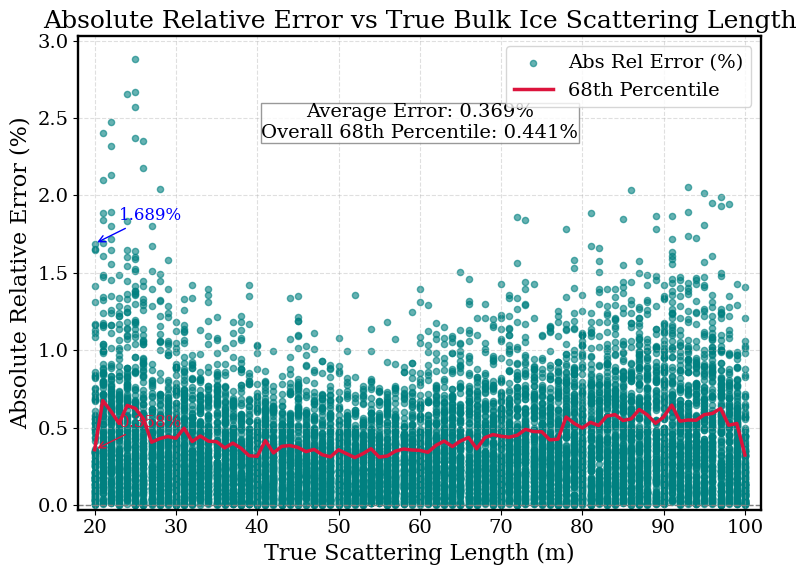

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# 가정: 아래 두 변수는 이미 정의되어 있습니다.
#    true_vals       : numpy array of shape (N,), 실제 Scattering Length (m)
#    abs_rel_errors  : numpy array of shape (N,), Absolute Relative Error (%) 
# ─────────────────────────────────────────────────────────────────────────────

# 1) 20 m ~ 100 m 범위 필터링
mask_range     = (true_vals >= 20) & (true_vals <= 100)
true_in_range  = true_vals[mask_range]
errs_in_range  = abs_rel_errors[mask_range]

# 2) 0% 오차를 살짝 위로 띄우기 위한 작은 오프셋 ε 정의
epsilon  = 1e-3  # 0.001% 만큼 위로 띄움
errs_plot = errs_in_range.copy()
errs_plot[errs_plot == 0] = epsilon

# 3) 고유한 True Scattering Length(범위 내) 구해서 정렬
unique_vals = np.unique(true_in_range)

# 4) 각 고유 값마다 68th percentile과 최대 오차 계산
percentiles_68 = []
max_errors     = []
for val in unique_vals:
    submask = (true_in_range == val)
    if np.any(submask):
        p68 = np.percentile(errs_in_range[submask], 68)
        mxe = np.max(errs_in_range[submask])
    else:
        p68 = np.nan
        mxe = np.nan
    percentiles_68.append(p68)
    max_errors.append(mxe)

percentiles_68 = np.array(percentiles_68)
max_errors     = np.array(max_errors)

# 5) y축 범위 설정
y_max = np.nanmax(np.concatenate((errs_in_range, percentiles_68[~np.isnan(percentiles_68)])))
y_min = -0.01 * y_max  # 0 아래로 약간 공간 확보

# 6) 전체 평균 및 전체 68th percentile 계산 (표시용)
avg_abs_rel_error = np.mean(errs_in_range)
overall_p68      = np.percentile(errs_in_range, 68)

# ─────────────────────────────────────────────────────────────────────────────
# 7) 그림 그리기: figsize=(8,6), x축에 약간 여유 공간 추가
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(8, 6))

# (A) Scatter: 모든 샘플 (20~100 m 범위)
plt.scatter(
    true_in_range,
    errs_plot,
    color='teal',
    s=20,
    alpha=0.6,
    label='Abs Rel Error (%)'
)

# (B) 68th percentile 선 그리기 (점 없이 선만)
plt.plot(
    unique_vals,
    percentiles_68,
    color='crimson',
    linewidth=2.5,
    label='68th Percentile'
)

# (C) x축 범위를 [18, 102] 로 여유 있게 설정
plt.xlim(18, 102)

# (D) y축 범위를 [y_min, y_max*1.05] 로 설정
plt.ylim(y_min, y_max * 1.05)

# (E) 0% 선 강조 (연한 회색 점선)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# (F) 축 레이블 및 제목, 글씨 크기 설정
plt.xlabel("True Scattering Length (m)", fontsize=16)
plt.ylabel("Absolute Relative Error (%)", fontsize=16)
plt.title("Absolute Relative Error vs True Bulk Ice Scattering Length", fontsize=18)

# (G) x축 눈금: 20, 30, …, 100
xticks = np.arange(20, 101, 10)
plt.xticks(xticks, fontsize=14)

# (H) y축 눈금 크기 설정
plt.yticks(fontsize=14)

# (I) 최대/최소 68th percentile 위치 표시 (예: 가장 작은 true length에서)
#     여기서는 첫 번째 unique_vals (== 20) 값만 예시로 표시합니다.
#     필요에 따라 여러 구간에 대해 반복해주세요.
x0 = unique_vals[0]
y_p68_0 = percentiles_68[0]
y_max_0 = max_errors[0]

# (I-1) 68th percentile 값에 화살표와 텍스트 추가
plt.annotate(
    f"{y_p68_0:.3f}%",             # 텍스트
    xy=(x0, y_p68_0),              # 화살표 끝 좌표
    xytext=(x0 + 3, y_p68_0 + 0.15),# 텍스트 위치 (오프셋 조정)
    fontsize=12, 
    color='crimson',
    arrowprops=dict(
        arrowstyle="->", 
        color='crimson'
    )
)

# (I-2) 최대 오차 값에 화살표와 텍스트 추가
plt.annotate(
    f"{y_max_0:.3f}%", 
    xy=(x0, y_max_0), 
    xytext=(x0 + 3, y_max_0 + 0.15), 
    fontsize=12, 
    color='blue',
    arrowprops=dict(
        arrowstyle="->", 
        color='blue'
    )
)

# (J) 전체 평균 및 전체 68th percentile 텍스트
mid_x = (18 + 102) / 2
plt.text(
    mid_x,
    y_max * 0.9,
    f"Average Error: {avg_abs_rel_error:.3f}%\n"
    f"Overall 68th Percentile: {overall_p68:.3f}%",
    fontsize=14,
    ha='center',
    va='top',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', pad=0.6)
)

# (K) 보조격자 추가
plt.grid(True, linestyle='--', alpha=0.4)

# (L) 범례 설정
plt.legend(fontsize=14, loc='upper right')

plt.tight_layout()
plt.show()

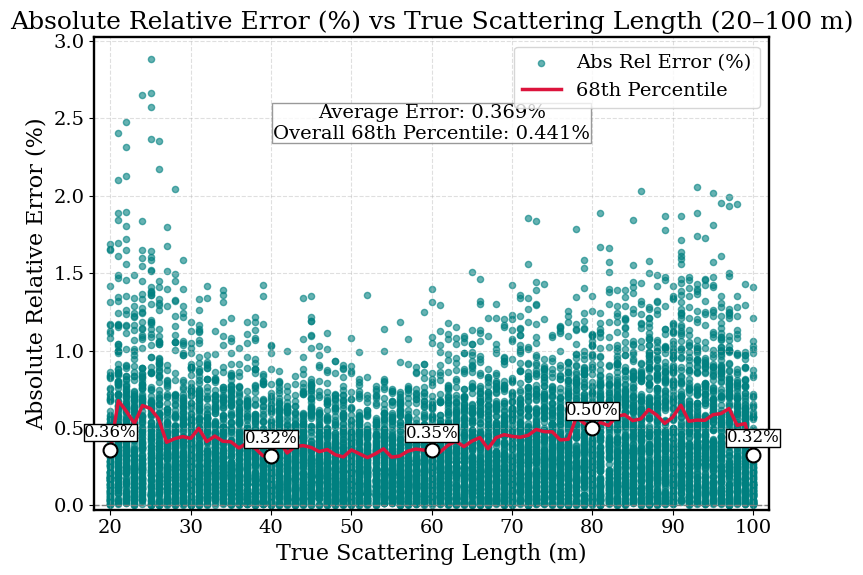

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# 가정: 아래 두 변수는 이미 정의되어 있습니다.
#    true_vals       : numpy array of shape (N,), 실제 Scattering Length (m)
#    abs_rel_errors  : numpy array of shape (N,), Absolute Relative Error (%) 
# ─────────────────────────────────────────────────────────────────────────────

# 1) 20 m ~ 100 m 범위 필터링
mask_range     = (true_vals >= 20) & (true_vals <= 100)
true_in_range  = true_vals[mask_range]
errs_in_range  = abs_rel_errors[mask_range]

# 2) 0% 오차를 살짝 위로 띄우기 위한 작은 오프셋 ε 정의
epsilon  = 1e-3  # 0.001% 만큼 위로 띄움
errs_plot = errs_in_range.copy()
errs_plot[errs_plot == 0] = epsilon

# 3) 고유한 True Scattering Length(범위 내) 구해서 정렬
unique_vals = np.unique(true_in_range)

# 4) 각 고유 값마다 68th percentile 계산
percentiles_68 = []
for val in unique_vals:
    submask = (true_in_range == val)
    if np.any(submask):
        p68 = np.percentile(errs_in_range[submask], 68)
    else:
        p68 = np.nan
    percentiles_68.append(p68)
percentiles_68 = np.array(percentiles_68)

# 5) 전체 범위의 최대 절대 상대 오차 구하기 (y 축 상한 설정에 사용)
y_max = np.nanmax(np.concatenate((errs_in_range, percentiles_68[~np.isnan(percentiles_68)])))

# 6) y축 하한을 작은 음수로 설정 (0%선이 x축 위로 살짝 올라오도록)
y_min = -0.01 * y_max

# 7) 전체 평균 및 전체 68th percentile 계산 (표시용)
avg_abs_rel_error = np.mean(errs_in_range)
overall_p68      = np.percentile(errs_in_range, 68)

# ─────────────────────────────────────────────────────────────────────────────
# 8) 그림 그리기: figsize=(8,6), x축에 약간 여유 공간 추가
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(8, 6))

# (A) Scatter: 모든 샘플 (20~100 m 범위) 그리기
plt.scatter(
    true_in_range,
    errs_plot,
    color='teal',
    s=20,
    alpha=0.6,
    label='Abs Rel Error (%)'
)

# (B) 68th percentile 선 그리기 (점 없이 선만)
plt.plot(
    unique_vals,
    percentiles_68,
    color='crimson',
    linewidth=2.5,
    label='68th Percentile'
)

# (C) x축 범위를 [18, 102] 로 여유 있게 설정
plt.xlim(18, 102)

# (D) y축 범위를 [y_min, y_max*1.05] 로 설정
plt.ylim(y_min, y_max * 1.05)

# (E) 0% 선 강조 (연한 회색 점선)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# (F) 축 레이블 및 제목, 글씨 크기 설정
plt.xlabel("True Scattering Length (m)", fontsize=16)
plt.ylabel("Absolute Relative Error (%)", fontsize=16)
plt.title("Absolute Relative Error (%) vs True Scattering Length (20–100 m)", fontsize=18)

# (G) x축 눈금: 20, 30, …, 100
xticks = np.arange(20, 101, 10)
plt.xticks(xticks, fontsize=14)

# (H) y축 눈금 크기 설정
plt.yticks(fontsize=14)

# (I) 평균 및 전체 68th percentile 텍스트
mid_x = (18 + 102) / 2
plt.text(
    mid_x,
    y_max * 0.9,
    f"Average Error: {avg_abs_rel_error:.3f}%\n"
    f"Overall 68th Percentile: {overall_p68:.3f}%",
    fontsize=14,
    ha='center',
    va='top',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', pad=0.6)
)

# (J) 20, 40, 60, 80, 100 위치에서 68th percentile 값 찾고 표시
highlight_xs = [20, 40, 60, 80, 100]
for hx in highlight_xs:
    # unique_vals 배열에서 정확히 일치하는 인덱스 찾기
    if hx in unique_vals:
        idx = np.where(unique_vals == hx)[0][0]
        p68_val = percentiles_68[idx]
        # (J-1) 빨간선 위에 흰색 채운 검은 테두리 원형 마커
        plt.scatter(
            [hx],
            [p68_val],
            facecolors='white',
            edgecolors='black',
            s=100,
            linewidths=1.5,
            zorder=5
        )
        # (J-2) 마커 바로 위에 텍스트: 흰색 배경, 검은색 글씨
        plt.text(
            hx,
            p68_val + y_max * 0.02,
            f"{p68_val:.2f}%",
            fontsize=12,
            color='black',
            ha='center',
            va='bottom',
            bbox=dict(facecolor='white', edgecolor='black', pad=0.3)
        )

# (K) 보조격자 추가
plt.grid(True, linestyle='--', alpha=0.4)

# (L) 범례 설정
plt.legend(fontsize=14, loc='upper right')

plt.tight_layout()
plt.show()

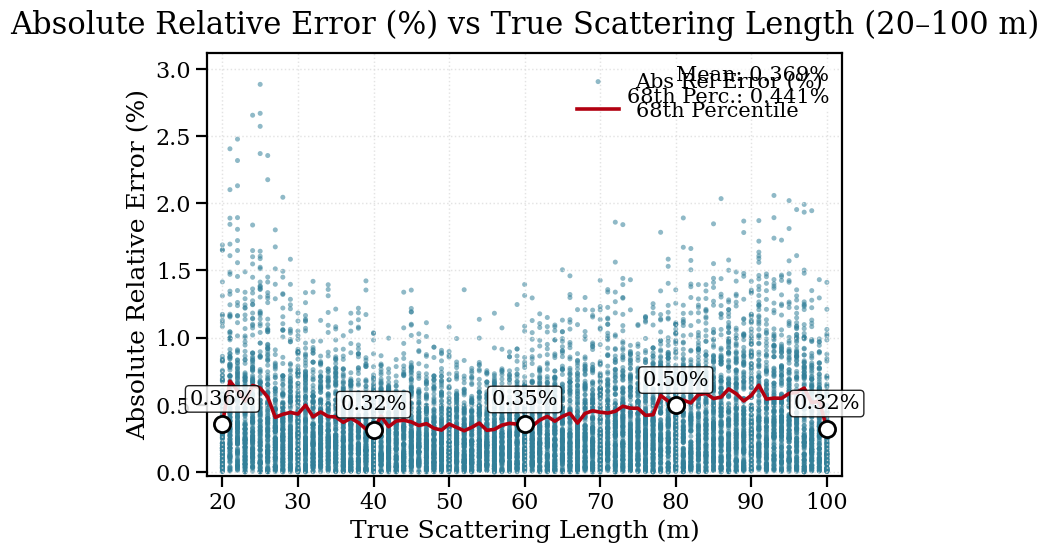

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# --- LaTeX 스타일 및 고급 설정
plt.rcParams.update({
    "font.family": "DejaVu Serif",
    "font.size": 16,
    "axes.titlesize": 22,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 15,
    "axes.linewidth": 1.7,
    "xtick.direction": "out",
    "ytick.direction": "out",
})

fig, ax = plt.subplots(figsize=(8, 6))

# --- Scatter: Error dots
ax.scatter(
    true_in_range, errs_plot,
    color='#338099', s=13, alpha=0.55, edgecolors='none', rasterized=True,
    label='Abs Rel Error (%)'
)

# --- 68th Percentile line (smoothed, thick)
ax.plot(
    unique_vals, percentiles_68,
    color='#B20010', lw=2.6, label='68th Percentile'
)

# --- X/Y limits
ax.set_xlim(18, 102)
ax.set_ylim(y_min, y_max * 1.08)

# --- Grid
ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)

# --- Axis & tick styling
ax.tick_params(axis='both', which='major', width=1.6, length=8)
ax.tick_params(axis='both', which='minor', width=1.0, length=4)
for spine in ax.spines.values():
    spine.set_linewidth(1.6)

# --- Highlighted percentile points
highlight_xs = [20, 40, 60, 80, 100]
for hx in highlight_xs:
    if hx in unique_vals:
        idx = np.where(unique_vals == hx)[0][0]
        p68_val = percentiles_68[idx]
        # White circle with black edge (bigger and bold)
        ax.scatter(
            [hx], [p68_val],
            s=135, facecolors='white', edgecolors='black', linewidths=2, zorder=10
        )
        # Text box just above marker
        ax.text(
            hx, p68_val + y_max*0.04, f"{p68_val:.2f}%", fontsize=15,
            color='black', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.18', facecolor='white', edgecolor='black', lw=1, alpha=0.85)
        )

# --- Mean/Percentile annotation (상단 우측)
ax.annotate(
    f"Mean: {avg_abs_rel_error:.3f}%\n68th Perc.: {overall_p68:.3f}%",
    xy=(0.98, 0.97), xycoords='axes fraction',
    ha='right', va='top', fontsize=15,
    bbox=dict(boxstyle='round,pad=0.22', facecolor='white', alpha=0.7, lw=0)
)

# --- Axis labels, title
ax.set_xlabel("True Scattering Length (m)")
ax.set_ylabel("Absolute Relative Error (%)")
ax.set_title("Absolute Relative Error (%) vs True Scattering Length (20–100 m)", pad=14)

# --- X ticks every 10 m
ax.set_xticks(np.arange(20, 101, 10))

# --- Legend (투명 배경, 테두리 X)
leg = ax.legend(loc='upper right', frameon=False)

plt.tight_layout(pad=1.5)
plt.show()

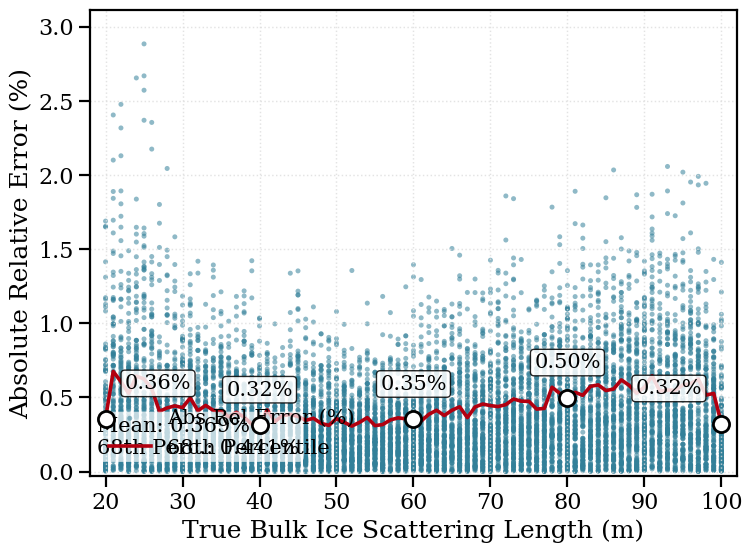

In [14]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "DejaVu Serif",
    "font.size": 16,
    "axes.titlesize": 22,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 15,
    "axes.linewidth": 1.7,
    "xtick.direction": "out",
    "ytick.direction": "out",
})

fig, ax = plt.subplots(figsize=(8, 6))

# --- Scatter: Error dots
ax.scatter(
    true_in_range, errs_plot,
    color='#338099', s=13, alpha=0.55, edgecolors='none', rasterized=True,
    label='Abs Rel Error (%)'
)

# --- 68th Percentile line (smoothed, thick)
ax.plot(
    unique_vals, percentiles_68,
    color='#B20010', lw=2.6, label='68th Percentile'
)

ax.set_xlim(18, 102)
ax.set_ylim(y_min, y_max * 1.08)
ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)
ax.tick_params(axis='both', which='major', width=1.6, length=8)
ax.tick_params(axis='both', which='minor', width=1.0, length=4)
for spine in ax.spines.values():
    spine.set_linewidth(1.6)

# Highlighted percentile points & value label positioning
highlight_xs = [20, 40, 60, 80, 100]
for hx in highlight_xs:
    if hx in unique_vals:
        idx = np.where(unique_vals == hx)[0][0]
        p68_val = percentiles_68[idx]
        ax.scatter(
            [hx], [p68_val],
            s=135, facecolors='white', edgecolors='black', linewidths=2, zorder=10
        )
        # 바깥쪽 값은 ha(정렬) 조정, 너무 위로 튀면 va도 'top'
        ha = 'center'
        if hx == 20:
            ha = 'left'
            x_text = hx + 2.5
        elif hx == 100:
            ha = 'right'
            x_text = hx - 2.5
        else:
            x_text = hx
        # 텍스트가 y축 넘지 않게 조절
        y_text = p68_val + y_max * 0.06
        if y_text > y_max * 1.08:
            y_text = p68_val - y_max * 0.08
            va = 'top'
        else:
            va = 'bottom'
        ax.text(
            x_text, y_text, f"{p68_val:.2f}%",
            fontsize=15, color='black', ha=ha, va=va,
            bbox=dict(boxstyle='round,pad=0.18', facecolor='white', edgecolor='black', lw=1, alpha=0.85),
            zorder=11
        )

# --- Axis labels
ax.set_xlabel("True Bulk Ice Scattering Length (m)")
ax.set_ylabel("Absolute Relative Error (%)")

# --- X ticks every 10 m
ax.set_xticks(np.arange(20, 101, 10))

# --- Legend (우상단이 겹치니, 아래쪽 왼쪽)
leg = ax.legend(loc='lower left', frameon=False)

# --- Mean/Percentile annotation (좌하단, 혹은 빈 곳에)
ax.annotate(
    f"Mean: {avg_abs_rel_error:.3f}%\n68th Perc.: {overall_p68:.3f}%",
    xy=(0.01, 0.04), xycoords='axes fraction',
    ha='left', va='bottom', fontsize=15,
    bbox=dict(boxstyle='round,pad=0.22', facecolor='white', alpha=0.7, lw=0)
)

plt.tight_layout(pad=1.5)
plt.show()


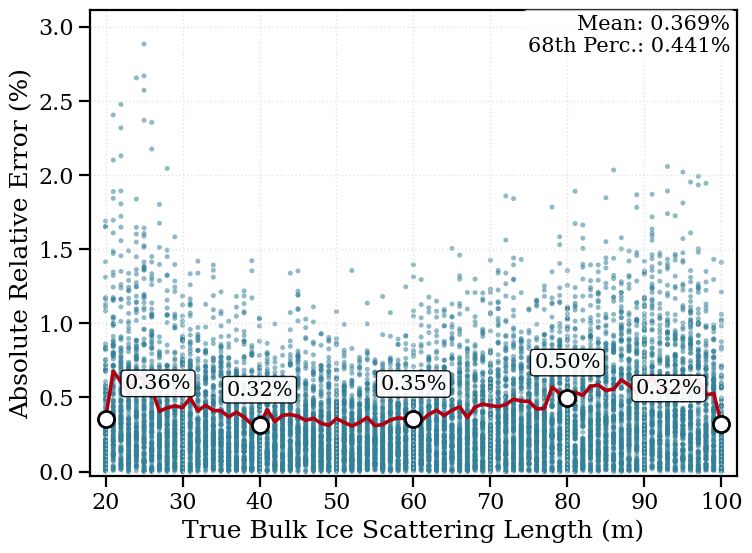

In [15]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "DejaVu Serif",
    "font.size": 16,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "axes.linewidth": 1.7,
    "xtick.direction": "out",
    "ytick.direction": "out",
})

fig, ax = plt.subplots(figsize=(8, 6))

# --- Scatter: Error dots
ax.scatter(
    true_in_range, errs_plot,
    color='#338099', s=13, alpha=0.55, edgecolors='none', rasterized=True,
)

# --- 68th Percentile line
ax.plot(
    unique_vals, percentiles_68,
    color='#B20010', lw=2.6
)

ax.set_xlim(18, 102)
ax.set_ylim(y_min, y_max * 1.08)
ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)
ax.tick_params(axis='both', which='major', width=1.6, length=8)
ax.tick_params(axis='both', which='minor', width=1.0, length=4)
for spine in ax.spines.values():
    spine.set_linewidth(1.6)

# Highlighted percentile points & value label positioning
highlight_xs = [20, 40, 60, 80, 100]
for hx in highlight_xs:
    if hx in unique_vals:
        idx = np.where(unique_vals == hx)[0][0]
        p68_val = percentiles_68[idx]
        ax.scatter(
            [hx], [p68_val],
            s=135, facecolors='white', edgecolors='black', linewidths=2, zorder=10
        )
        ha = 'center'
        if hx == 20:
            ha = 'left'
            x_text = hx + 2.5
        elif hx == 100:
            ha = 'right'
            x_text = hx - 2.5
        else:
            x_text = hx
        y_text = p68_val + y_max * 0.06
        if y_text > y_max * 1.08:
            y_text = p68_val - y_max * 0.08
            va = 'top'
        else:
            va = 'bottom'
        ax.text(
            x_text, y_text, f"{p68_val:.2f}%",
            fontsize=15, color='black', ha=ha, va=va,
            bbox=dict(boxstyle='round,pad=0.18', facecolor='white', edgecolor='black', lw=1, alpha=0.92),
            zorder=11
        )

# --- Axis labels
ax.set_xlabel("True Bulk Ice Scattering Length (m)")
ax.set_ylabel("Absolute Relative Error (%)")

# --- X ticks every 10 m
ax.set_xticks(np.arange(20, 101, 10))

# --- Mean/Percentile annotation (오른쪽 위)
ax.annotate(
    f"Mean: {avg_abs_rel_error:.3f}%\n68th Perc.: {overall_p68:.3f}%",
    xy=(0.99, 0.99), xycoords='axes fraction',
    ha='right', va='top', fontsize=15,
    bbox=dict(boxstyle='round,pad=0.22', facecolor='white', alpha=0.75, lw=0)
)

plt.tight_layout(pad=1.5)
plt.show()


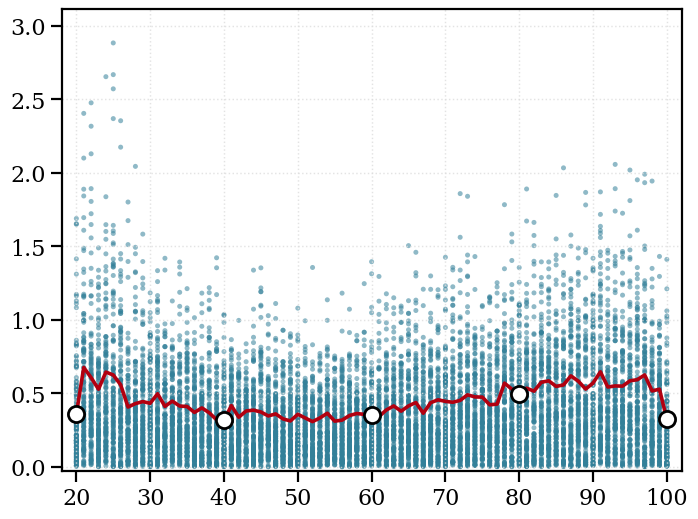

In [16]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "DejaVu Serif",
    "font.size": 16,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "axes.linewidth": 1.7,
    "xtick.direction": "out",
    "ytick.direction": "out",
})

fig, ax = plt.subplots(figsize=(8, 6))

# --- Scatter: Error dots
scatter = ax.scatter(
    true_in_range, errs_plot,
    color='#338099', s=13, alpha=0.55, edgecolors='none', rasterized=True,
)

# --- 68th Percentile line
line, = ax.plot(
    unique_vals, percentiles_68,
    color='#B20010', lw=2.6
)

ax.set_xlim(18, 102)
ax.set_ylim(y_min, y_max * 1.08)
ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)
ax.tick_params(axis='both', which='major', width=1.6, length=8)
ax.tick_params(axis='both', which='minor', width=1.0, length=4)
for spine in ax.spines.values():
    spine.set_linewidth(1.6)

# Highlighted percentile points & value label positioning
highlight_xs = [20, 40, 60, 80, 100]
for hx in highlight_xs:
    if hx in unique_vals:
        idx = np.where(unique_vals == hx)[0][0]
        p68_val = percentiles_68[idx]
        ax.scatter(
            [hx], [p68_val],
            s=135, facecolors='white', edgecolors='black', linewidths=2, zorder=10
        )
        ha = 'center'
        if hx == 20:
            ha = 'left'


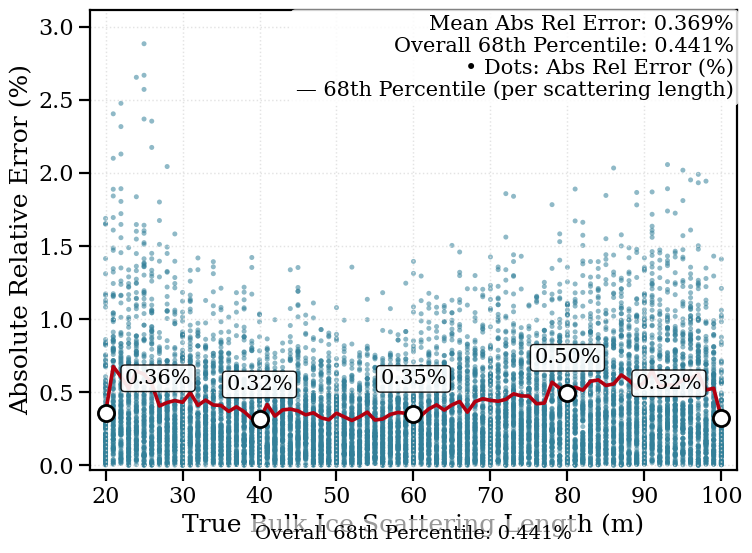

In [17]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "DejaVu Serif",
    "font.size": 16,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "axes.linewidth": 1.7,
    "xtick.direction": "out",
    "ytick.direction": "out",
})

fig, ax = plt.subplots(figsize=(8, 6))

# --- Scatter: Error dots
scatter = ax.scatter(
    true_in_range, errs_plot,
    color='#338099', s=13, alpha=0.55, edgecolors='none', rasterized=True,
)

# --- 68th Percentile line
line, = ax.plot(
    unique_vals, percentiles_68,
    color='#B20010', lw=2.6
)

ax.set_xlim(18, 102)
ax.set_ylim(y_min, y_max * 1.08)
ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)
ax.tick_params(axis='both', which='major', width=1.6, length=8)
ax.tick_params(axis='both', which='minor', width=1.0, length=4)
for spine in ax.spines.values():
    spine.set_linewidth(1.6)

# Highlighted percentile points & value label positioning
highlight_xs = [20, 40, 60, 80, 100]
for hx in highlight_xs:
    if hx in unique_vals:
        idx = np.where(unique_vals == hx)[0][0]
        p68_val = percentiles_68[idx]
        ax.scatter(
            [hx], [p68_val],
            s=135, facecolors='white', edgecolors='black', linewidths=2, zorder=10
        )
        ha = 'center'
        if hx == 20:
            ha = 'left'
            x_text = hx + 2.5
        elif hx == 100:
            ha = 'right'
            x_text = hx - 2.5
        else:
            x_text = hx
        y_text = p68_val + y_max * 0.06
        if y_text > y_max * 1.08:
            y_text = p68_val - y_max * 0.08
            va = 'top'
        else:
            va = 'bottom'
        ax.text(
            x_text, y_text, f"{p68_val:.2f}%",
            fontsize=15, color='black', ha=ha, va=va,
            bbox=dict(boxstyle='round,pad=0.18', facecolor='white', edgecolor='black', lw=1, alpha=0.90),
            zorder=11
        )

# --- Axis labels
ax.set_xlabel("True Bulk Ice Scattering Length (m)")
ax.set_ylabel("Absolute Relative Error (%)")

# --- X ticks every 10 m
ax.set_xticks(np.arange(20, 101, 10))

# --- 우상단: 상세 설명 포함
summary_str = (
    f"Mean Abs Rel Error: {avg_abs_rel_error:.3f}%\n"
    f"Overall 68th Percentile: {overall_p68:.3f}%\n"
    r"• Dots: Abs Rel Error (%)"
    "\n— 68th Percentile (per scattering length)"
)
ax.annotate(
    summary_str,
    xy=(0.995, 0.99), xycoords='axes fraction',
    ha='right', va='top', fontsize=15,
    bbox=dict(boxstyle='round,pad=0.25', facecolor='white', alpha=0.83, lw=0)
)

# --- 하단 전체 구간 퍼센타일(필요시 주석)
ax.text(
    0.5, -0.14,
    f"Overall 68th Percentile: {overall_p68:.3f}%",
    ha='center', va='center', fontsize=14, color='black',
    transform=ax.transAxes,
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
)

plt.tight_layout(pad=1.5)
plt.show()

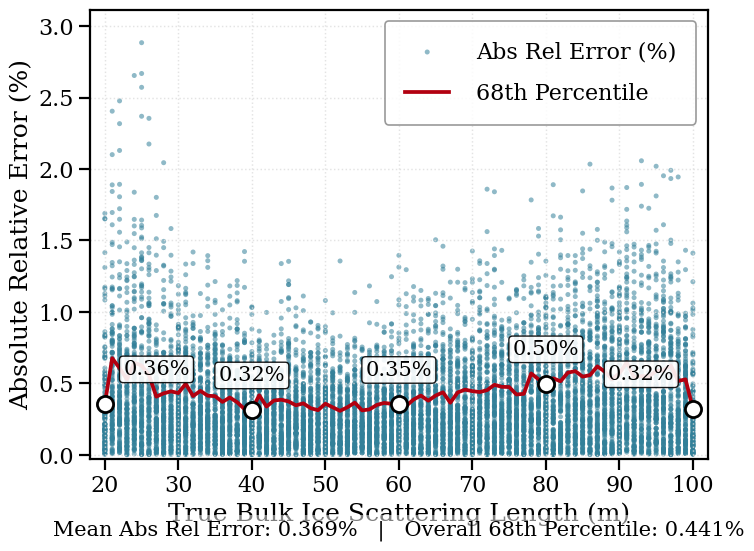

In [18]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "DejaVu Serif",
    "font.size": 16,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "axes.linewidth": 1.7,
    "xtick.direction": "out",
    "ytick.direction": "out",
})

fig, ax = plt.subplots(figsize=(8, 6))

dot_color = '#338099'
line_color = '#B20010'

# --- Scatter: Error dots
sc = ax.scatter(
    true_in_range, errs_plot,
    color=dot_color, s=13, alpha=0.55, edgecolors='none', rasterized=True,
    label='Abs Rel Error (%)'
)

# --- 68th Percentile line
ln, = ax.plot(
    unique_vals, percentiles_68,
    color=line_color, lw=2.7, label='68th Percentile'
)

ax.set_xlim(18, 102)
ax.set_ylim(y_min, y_max * 1.08)
ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)
ax.tick_params(axis='both', which='major', width=1.6, length=8)
ax.tick_params(axis='both', which='minor', width=1.0, length=4)
for spine in ax.spines.values():
    spine.set_linewidth(1.6)

# Highlighted percentile points & value label positioning
highlight_xs = [20, 40, 60, 80, 100]
for hx in highlight_xs:
    if hx in unique_vals:
        idx = np.where(unique_vals == hx)[0][0]
        p68_val = percentiles_68[idx]
        ax.scatter(
            [hx], [p68_val],
            s=135, facecolors='white', edgecolors='black', linewidths=2, zorder=10
        )
        ha = 'center'
        if hx == 20:
            ha = 'left'
            x_text = hx + 2.5
        elif hx == 100:
            ha = 'right'
            x_text = hx - 2.5
        else:
            x_text = hx
        y_text = p68_val + y_max * 0.06
        if y_text > y_max * 1.08:
            y_text = p68_val - y_max * 0.08
            va = 'top'
        else:
            va = 'bottom'
        ax.text(
            x_text, y_text, f"{p68_val:.2f}%",
            fontsize=15, color='black', ha=ha, va=va,
            bbox=dict(boxstyle='round,pad=0.18', facecolor='white', edgecolor='black', lw=1, alpha=0.90),
            zorder=11
        )

# --- Axis labels
ax.set_xlabel("True Bulk Ice Scattering Length (m)")
ax.set_ylabel("Absolute Relative Error (%)")
ax.set_xticks(np.arange(20, 101, 10))

# --- 전문적 스타일의 legend
legend = ax.legend(
    handles=[sc, ln],
    labels=['Abs Rel Error (%)', '68th Percentile'],
    loc='upper right', frameon=True, fontsize=16,
    handletextpad=1.2, borderpad=0.9, labelspacing=0.9,
    fancybox=True, framealpha=0.85, facecolor='white', edgecolor='#888'
)
legend.get_frame().set_linewidth(1.2)

# --- 전체 68th Percentile, Mean 하단에
ax.text(
    0.5, -0.16,
    f"Mean Abs Rel Error: {avg_abs_rel_error:.3f}%   |   Overall 68th Percentile: {overall_p68:.3f}%",
    ha='center', va='center', fontsize=15, color='black',
    transform=ax.transAxes,
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
)

plt.tight_layout(pad=1.5)
plt.show()

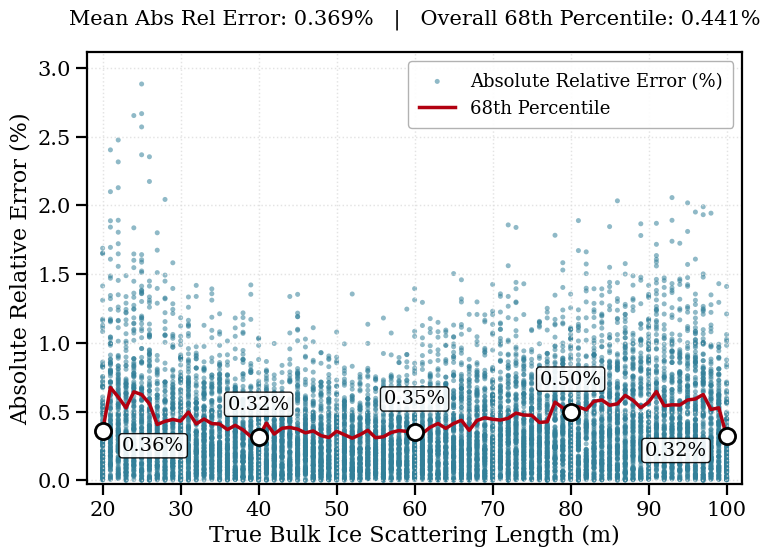

In [19]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "DejaVu Serif",
    "font.size": 15,
    "axes.labelsize": 16,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "axes.linewidth": 1.7,
    "xtick.direction": "out",
    "ytick.direction": "out",
})

fig, ax = plt.subplots(figsize=(8, 6))

dot_color = '#338099'
line_color = '#B20010'

# --- Scatter: Error dots
sc = ax.scatter(
    true_in_range, errs_plot,
    color=dot_color, s=13, alpha=0.55, edgecolors='none', rasterized=True,
    label='Absolute Relative Error (%)'
)

# --- 68th Percentile line
ln, = ax.plot(
    unique_vals, percentiles_68,
    color=line_color, lw=2.5, label='68th Percentile'
)

ax.set_xlim(18, 102)
ax.set_ylim(y_min, y_max * 1.08)
ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)
ax.tick_params(axis='both', which='major', width=1.6, length=8)
ax.tick_params(axis='both', which='minor', width=1.0, length=4)
for spine in ax.spines.values():
    spine.set_linewidth(1.6)

# Highlighted percentile points & value label positioning
highlight_xs = [20, 40, 60, 80, 100]
for hx in highlight_xs:
    if hx in unique_vals:
        idx = np.where(unique_vals == hx)[0][0]
        p68_val = percentiles_68[idx]
        # 사각형 y위치: 첫/끝은 더 아래, 나머지는 기본 방식
        if hx in [20, 100]:
            y_text = p68_val - y_max * 0.014  # 많이 내림
            va = 'top'
        else:
            y_text = p68_val + y_max * 0.06
            va = 'bottom'
        ax.scatter(
            [hx], [p68_val],
            s=135, facecolors='white', edgecolors='black', linewidths=2, zorder=10
        )
        ha = 'center'
        if hx == 20:
            ha = 'left'
            x_text = hx + 2.5
        elif hx == 100:
            ha = 'right'
            x_text = hx - 2.5
        else:
            x_text = hx
        ax.text(
            x_text, y_text, f"{p68_val:.2f}%",
            fontsize=14, color='black', ha=ha, va=va,
            bbox=dict(boxstyle='round,pad=0.16', facecolor='white', edgecolor='black', lw=1, alpha=0.90),
            zorder=11
        )

# --- Axis labels
ax.set_xlabel("True Bulk Ice Scattering Length (m)")
ax.set_ylabel("Absolute Relative Error (%)")
ax.set_xticks(np.arange(20, 101, 10))

# --- 제목에 mean/68th 표시 (크기 작게)
title_txt = f"Mean Abs Rel Error: {avg_abs_rel_error:.3f}%   |   Overall 68th Percentile: {overall_p68:.3f}%"
ax.set_title(title_txt, fontsize=15, pad=20)

# --- legend 작게, 예쁘게
legend = ax.legend(
    handles=[sc, ln],
    labels=['Absolute Relative Error (%)', '68th Percentile'],
    loc='upper right', frameon=True, fontsize=13,
    handletextpad=0.8, borderpad=0.6, labelspacing=0.5,
    fancybox=True, framealpha=0.90, facecolor='white', edgecolor='#AAA'
)
legend.get_frame().set_linewidth(1.0)

plt.tight_layout(pad=1.5)
plt.show()

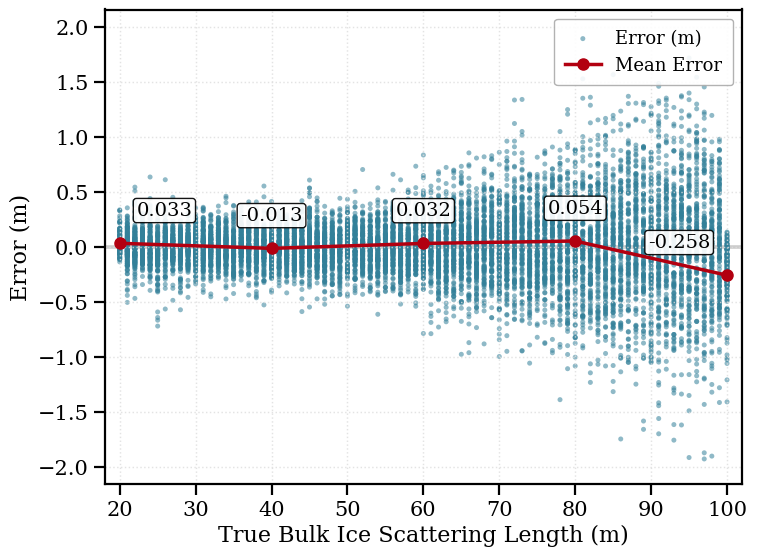

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_error_with_means_clipped(true_in_range, errors_in_range):
    plt.rcParams.update({
        "font.family": "DejaVu Serif",
        "font.size": 15,
        "axes.labelsize": 16,
        "xtick.labelsize": 15,
        "ytick.labelsize": 15,
        "axes.linewidth": 1.7,
        "xtick.direction": "out",
        "ytick.direction": "out",
    })
    fig, ax = plt.subplots(figsize=(8, 6))
    dot_color = '#338099'
    line_color = '#B20010'

    # --- Scatter: Error dots
    sc = ax.scatter(
        true_in_range, errors_in_range,
        color=dot_color, s=13, alpha=0.55, edgecolors='none', rasterized=True,
        label='Error (m)'
    )

    # --- 20, 40, 60, 80, 100m에서의 평균 에러 계산
    highlight_xs = [20, 40, 60, 80, 100]
    mean_ys = []
    for hx in highlight_xs:
        mask = (true_in_range == hx)
        if np.any(mask):
            mean_y = np.mean(errors_in_range[mask])
        else:
            mean_y = np.nan
        mean_ys.append(mean_y)
    mean_ys = np.array(mean_ys)

    # --- 빨간 선: 평균 연결
    ln, = ax.plot(
        highlight_xs, mean_ys,
        color=line_color, lw=2.5, marker='o', markersize=8,
        label='Mean Error'
    )

    # --- y축 범위 자동, padding 추가
    y_margin = 0.12
    y_max = np.nanmax([np.abs(errors_in_range).max(), np.abs(mean_ys).max()])
    ylim = (-y_max - y_margin*y_max, y_max + y_margin*y_max)
    ax.set_ylim(*ylim)

    ax.set_xlabel("True Bulk Ice Scattering Length (m)")
    ax.set_ylabel("Error (m)")
    ax.set_xticks(np.arange(20, 101, 10))
    ax.set_xlim(18, 102)
    ax.tick_params(axis='both', which='major', width=1.6, length=8)
    ax.tick_params(axis='both', which='minor', width=1.0, length=4)
    for spine in ax.spines.values():
        spine.set_linewidth(1.6)

    ax.axhline(0, color='gray', linestyle='-', linewidth=2.6, zorder=0, alpha=0.4)
    ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)

    legend = ax.legend(
        handles=[sc, ln],
        labels=['Error (m)', 'Mean Error'],
        loc='upper right', frameon=True, fontsize=13,
        handletextpad=0.8, borderpad=0.6, labelspacing=0.5,
        fancybox=True, framealpha=0.90, facecolor='white', edgecolor='#AAA'
    )
    legend.get_frame().set_linewidth(1.0)

    # --- 평균값 박스가 x축 경계(20, 100)에서 너무 바깥에 붙지 않게
    box_offsets = {20: 2.2, 100: -2.2}  # +x(20), -x(100) 방향으로 박스 이동
    for hx, my in zip(highlight_xs, mean_ys):
        if np.isnan(my):
            continue
        ypad = 0.05 * (ylim[1] - ylim[0])
        # 위치
        y_text = my + ypad
        va = 'bottom'
        # y경계 체크
        if y_text > ylim[1] - 0.03*y_max:
            y_text = my - ypad
            va = 'top'
        if y_text < ylim[0] + 0.03*y_max:
            y_text = my + ypad
            va = 'bottom'
        # x경계: 20, 100일 때만 좌우로 살짝 이동
        x_text = hx + box_offsets[hx] if hx in box_offsets else hx
        ha = 'left' if hx == 20 else 'right' if hx == 100 else 'center'
        ax.text(
            x_text, y_text, f"{my:.3f}",
            fontsize=14, color='black', ha=ha, va=va,
            bbox=dict(boxstyle='round,pad=0.16', facecolor='white', edgecolor='black', lw=1, alpha=0.92),
            zorder=11
        )

    plt.tight_layout(pad=1.5)
    return fig, ax

# ---- 실제 사용 ----
# (true_vals, pred_vals 준비되어 있다고 가정)
mask_range = (true_vals >= 20) & (true_vals <= 100)
true_in_range = true_vals[mask_range]
pred_in_range = pred_vals[mask_range]
errors_in_range = pred_in_range - true_in_range

fig, ax = plot_error_with_means_clipped(true_in_range, errors_in_range)
plt.show()


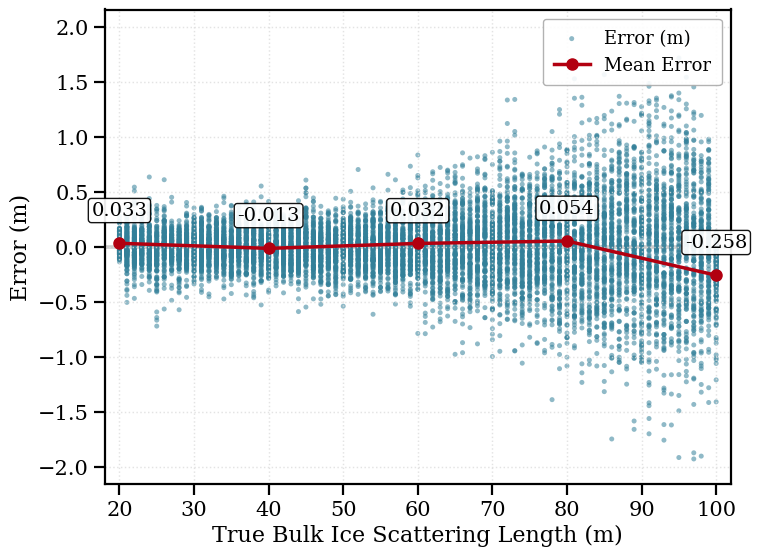

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def plot_error_with_means_and_clip(true_in_range, errors_in_range):
    plt.rcParams.update({
        "font.family": "DejaVu Serif",
        "font.size": 15,
        "axes.labelsize": 16,
        "xtick.labelsize": 15,
        "ytick.labelsize": 15,
        "axes.linewidth": 1.7,
        "xtick.direction": "out",
        "ytick.direction": "out",
    })
    fig, ax = plt.subplots(figsize=(8, 6))
    dot_color = '#338099'
    line_color = '#B20010'

    # --- Scatter: Error dots
    sc = ax.scatter(
        true_in_range, errors_in_range,
        color=dot_color, s=13, alpha=0.55, edgecolors='none', rasterized=True,
        label='Error (m)'
    )

    # --- 20, 40, 60, 80, 100m에서의 평균 에러 계산
    highlight_xs = [20, 40, 60, 80, 100]
    mean_ys = []
    for hx in highlight_xs:
        mask = (true_in_range == hx)
        if np.any(mask):
            mean_y = np.mean(errors_in_range[mask])
        else:
            mean_y = np.nan
        mean_ys.append(mean_y)
    mean_ys = np.array(mean_ys)

    # --- 빨간 선: 평균 연결
    ln, = ax.plot(
        highlight_xs, mean_ys,
        color=line_color, lw=2.5, marker='o', markersize=8,
        label='Mean Error'
    )

    # --- y축 범위 자동, padding 추가
    y_margin = 0.12  # y축 최대/최소에서 12% padding
    y_max = np.nanmax([np.abs(errors_in_range).max(), np.abs(mean_ys).max()])
    ylim = (-y_max - y_margin*y_max, y_max + y_margin*y_max)
    ax.set_ylim(*ylim)

    # --- xticks
    ax.set_xlabel("True Bulk Ice Scattering Length (m)")
    ax.set_ylabel("Error (m)")
    ax.set_xticks(np.arange(20, 101, 10))
    ax.set_xlim(18, 102)
    ax.tick_params(axis='both', which='major', width=1.6, length=8)
    ax.tick_params(axis='both', which='minor', width=1.0, length=4)
    for spine in ax.spines.values():
        spine.set_linewidth(1.6)

    # --- y=0 강조: 굵은 회색 선
    ax.axhline(0, color='gray', linestyle='-', linewidth=2.6, zorder=0, alpha=0.4)

    # --- 그리드
    ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)

    # --- legend (작고 깔끔하게)
    legend = ax.legend(
        handles=[sc, ln],
        labels=['Error (m)', 'Mean Error'],
        loc='upper right', frameon=True, fontsize=13,
        handletextpad=0.8, borderpad=0.6, labelspacing=0.5,
        fancybox=True, framealpha=0.90, facecolor='white', edgecolor='#AAA'
    )
    legend.get_frame().set_linewidth(1.0)

    # --- 평균값 박스가 플롯 영역 밖으로 나가지 않도록 위치 자동 조정
    for hx, my in zip(highlight_xs, mean_ys):
        if np.isnan(my):
            continue
        ypad = 0.05 * (ylim[1] - ylim[0])
        # 위로 위치
        y_text = my + ypad
        va = 'bottom'
        # 만약 위쪽 경계 넘으면, 아래로
        if y_text > ylim[1] - 0.03*y_max:
            y_text = my - ypad
            va = 'top'
        # 아래쪽도 검사
        if y_text < ylim[0] + 0.03*y_max:
            y_text = my + ypad
            va = 'bottom'
        ax.text(
            hx, y_text, f"{my:.3f}",
            fontsize=14, color='black', ha='center', va=va,
            bbox=dict(boxstyle='round,pad=0.16', facecolor='white', edgecolor='black', lw=1, alpha=0.92),
            zorder=11
        )

    # --- 제목 없애고, 여백 적당히
    plt.tight_layout(pad=1.5)
    return fig, ax

# ---- 실제 사용 ----
# (true_vals, pred_vals 준비되어 있다고 가정)
mask_range = (true_vals >= 20) & (true_vals <= 100)
true_in_range = true_vals[mask_range]
pred_in_range = pred_vals[mask_range]
errors_in_range = pred_in_range - true_in_range

fig1, ax1 = plot_error_with_means_and_clip(true_in_range, errors_in_range)
plt.show()


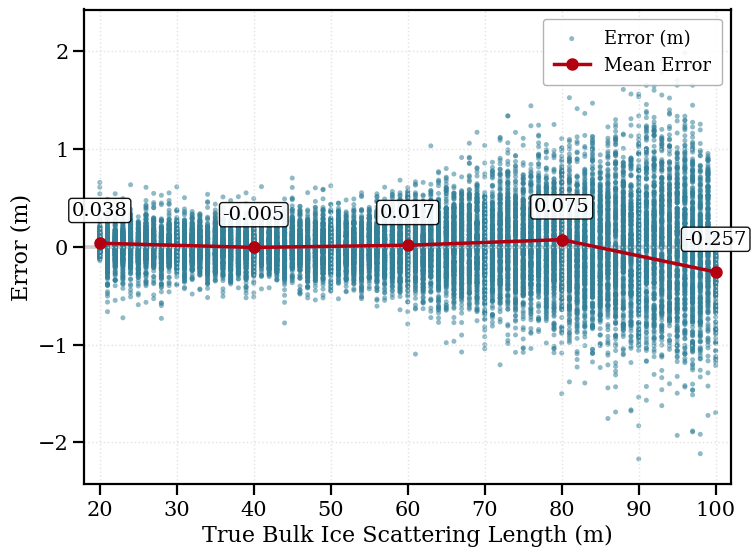

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_error_with_means_and_clip(true_in_range, errors_in_range):
    plt.rcParams.update({
        "font.family": "DejaVu Serif",
        "font.size": 15,
        "axes.labelsize": 16,
        "xtick.labelsize": 15,
        "ytick.labelsize": 15,
        "axes.linewidth": 1.7,
        "xtick.direction": "out",
        "ytick.direction": "out",
    })
    fig, ax = plt.subplots(figsize=(8, 6))
    dot_color = '#338099'
    line_color = '#B20010'

    # --- Scatter: Error dots
    sc = ax.scatter(
        true_in_range, errors_in_range,
        color=dot_color, s=13, alpha=0.55, edgecolors='none', rasterized=True,
        label='Error (m)'
    )

    # --- 20, 40, 60, 80, 100m에서의 평균 에러 계산
    highlight_xs = [20, 40, 60, 80, 100]
    mean_ys = []
    for hx in highlight_xs:
        mask = (true_in_range == hx)
        if np.any(mask):
            mean_y = np.mean(errors_in_range[mask])
        else:
            mean_y = np.nan
        mean_ys.append(mean_y)
    mean_ys = np.array(mean_ys)

    # --- 빨간 선: 평균 연결
    ln, = ax.plot(
        highlight_xs, mean_ys,
        color=line_color, lw=2.5, marker='o', markersize=8,
        label='Mean Error'
    )

    # --- y축 범위 자동, padding 추가
    y_margin = 0.12  # y축 최대/최소에서 12% padding
    y_max = np.nanmax([np.abs(errors_in_range).max(), np.abs(mean_ys).max()])
    ylim = (-y_max - y_margin*y_max, y_max + y_margin*y_max)
    ax.set_ylim(*ylim)

    # --- xticks
    ax.set_xlabel("True Bulk Ice Scattering Length (m)")
    ax.set_ylabel("Error (m)")
    ax.set_xticks(np.arange(20, 101, 10))
    ax.set_xlim(18, 102)
    ax.tick_params(axis='both', which='major', width=1.6, length=8)
    ax.tick_params(axis='both', which='minor', width=1.0, length=4)
    for spine in ax.spines.values():
        spine.set_linewidth(1.6)

    # --- y=0 강조: 굵은 회색 선
    ax.axhline(0, color='gray', linestyle='-', linewidth=2.6, zorder=0, alpha=0.4)

    # --- 그리드
    ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)

    # --- legend (작고 깔끔하게)
    legend = ax.legend(
        handles=[sc, ln],
        labels=['Error (m)', 'Mean Error'],
        loc='upper right', frameon=True, fontsize=13,
        handletextpad=0.8, borderpad=0.6, labelspacing=0.5,
        fancybox=True, framealpha=0.90, facecolor='white', edgecolor='#AAA'
    )
    legend.get_frame().set_linewidth(1.0)

    # --- 평균값 박스가 플롯 영역 밖으로 나가지 않도록 위치 자동 조정
    for hx, my in zip(highlight_xs, mean_ys):
        if np.isnan(my):
            continue
        ypad = 0.05 * (ylim[1] - ylim[0])
        # 위로 위치
        y_text = my + ypad
        va = 'bottom'
        # 만약 위쪽 경계 넘으면, 아래로
        if y_text > ylim[1] - 0.03*y_max:
            y_text = my - ypad
            va = 'top'
        # 아래쪽도 검사
        if y_text < ylim[0] + 0.03*y_max:
            y_text = my + ypad
            va = 'bottom'
        ax.text(
            hx, y_text, f"{my:.3f}",
            fontsize=14, color='black', ha='center', va=va,
            bbox=dict(boxstyle='round,pad=0.16', facecolor='white', edgecolor='black', lw=1, alpha=0.92),
            zorder=11
        )

    # --- 제목 없애고, 여백 적당히
    plt.tight_layout(pad=1.5)
    return fig, ax

# ---- 실제 사용 ----
# (true_vals, pred_vals 준비되어 있다고 가정)
mask_range = (true_vals >= 20) & (true_vals <= 100)
true_in_range = true_vals[mask_range]
pred_in_range = pred_vals[mask_range]
errors_in_range = pred_in_range - true_in_range

fig1, ax1 = plot_error_with_means_and_clip(true_in_range, errors_in_range)
plt.show()

In [ ]:
print()

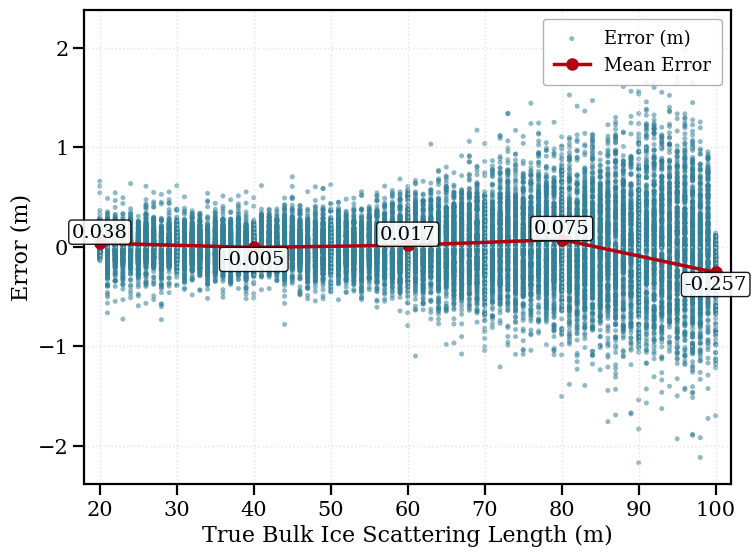

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# true_vals, pred_vals 이미 numpy array로 준비되어 있다고 가정

# 1) 20~100 범위 필터링
mask_range = (true_vals >= 20) & (true_vals <= 100)
true_in_range = true_vals[mask_range]
pred_in_range = pred_vals[mask_range]
errors_in_range = pred_in_range - true_in_range

# 2) plot
plt.rcParams.update({
    "font.family": "DejaVu Serif",
    "font.size": 15,
    "axes.labelsize": 16,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "axes.linewidth": 1.7,
    "xtick.direction": "out",
    "ytick.direction": "out",
})

fig, ax = plt.subplots(figsize=(8, 6))
dot_color = '#338099'
line_color = '#B20010'

# --- Scatter: Error dots
sc = ax.scatter(
    true_in_range, errors_in_range,
    color=dot_color, s=13, alpha=0.55, edgecolors='none', rasterized=True,
    label='Error (m)'
)

# --- 20, 40, 60, 80, 100m에서의 평균 에러 계산
highlight_xs = [20, 40, 60, 80, 100]
mean_ys = []
for hx in highlight_xs:
    mask = (true_in_range == hx)
    if np.any(mask):
        mean_y = np.mean(errors_in_range[mask])
    else:
        mean_y = np.nan
    mean_ys.append(mean_y)
mean_ys = np.array(mean_ys)

# --- 빨간 선: 평균 연결
ln, = ax.plot(
    highlight_xs, mean_ys,
    color=line_color, lw=2.5, marker='o', markersize=8,
    label='Mean Error'
)

# --- 숫자 표기
for hx, my in zip(highlight_xs, mean_ys):
    if not np.isnan(my):
        y_text = my + (0.02 if my >= 0 else -0.03)
        ax.text(
            hx, y_text, f"{my:.3f}",
            fontsize=14, color='black', ha='center',
            va='bottom' if my >= 0 else 'top',
            bbox=dict(boxstyle='round,pad=0.16', facecolor='white', edgecolor='black', lw=1, alpha=0.90),
            zorder=11
        )

# --- 축/스타일
ax.set_xlabel("True Bulk Ice Scattering Length (m)")
ax.set_ylabel("Error (m)")
ax.set_xticks(np.arange(20, 101, 10))
ax.set_xlim(18, 102)
y_lim = max(np.abs(errors_in_range).max(), np.abs(mean_ys).max()) * 1.1
ax.set_ylim(-y_lim, y_lim)
ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)
ax.tick_params(axis='both', which='major', width=1.6, length=8)
ax.tick_params(axis='both', which='minor', width=1.0, length=4)
for spine in ax.spines.values():
    spine.set_linewidth(1.6)

# --- legend 예쁘게
legend = ax.legend(
    handles=[sc, ln],
    labels=['Error (m)', 'Mean Error'],
    loc='upper right', frameon=True, fontsize=13,
    handletextpad=0.8, borderpad=0.6, labelspacing=0.5,
    fancybox=True, framealpha=0.90, facecolor='white', edgecolor='#AAA'
)
legend.get_frame().set_linewidth(1.0)

plt.tight_layout(pad=1.5)
plt.show()


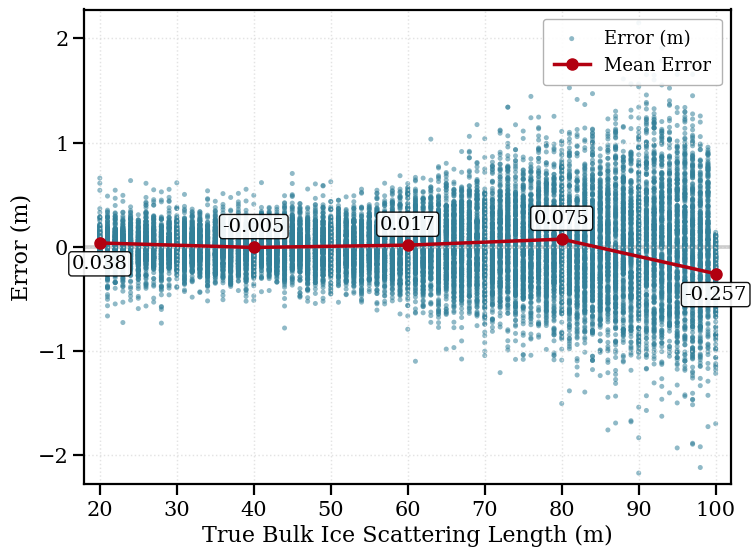

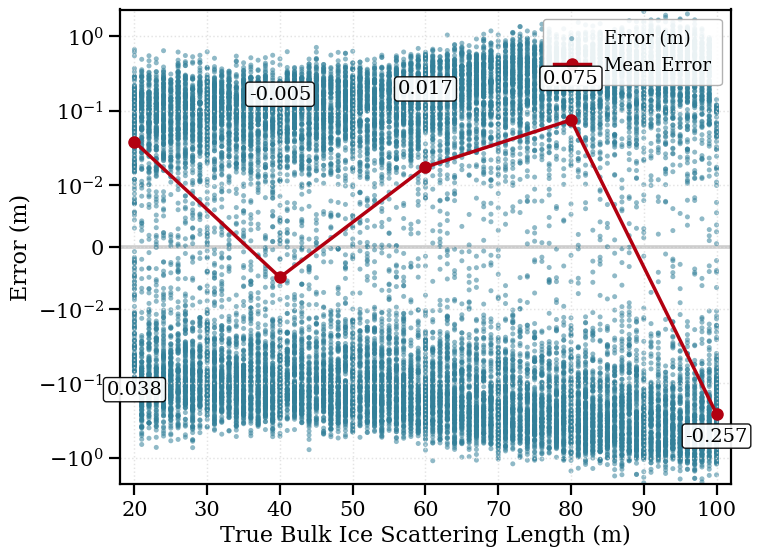

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def plot_error_with_means(true_in_range, errors_in_range, ylog=False):
    plt.rcParams.update({
        "font.family": "DejaVu Serif",
        "font.size": 15,
        "axes.labelsize": 16,
        "xtick.labelsize": 15,
        "ytick.labelsize": 15,
        "axes.linewidth": 1.7,
        "xtick.direction": "out",
        "ytick.direction": "out",
    })
    fig, ax = plt.subplots(figsize=(8, 6))
    dot_color = '#338099'
    line_color = '#B20010'

    # --- Scatter: Error dots
    sc = ax.scatter(
        true_in_range, errors_in_range,
        color=dot_color, s=13, alpha=0.55, edgecolors='none', rasterized=True,
        label='Error (m)'
    )

    # --- 20, 40, 60, 80, 100m에서의 평균 에러 계산
    highlight_xs = [20, 40, 60, 80, 100]
    mean_ys = []
    for hx in highlight_xs:
        mask = (true_in_range == hx)
        if np.any(mask):
            mean_y = np.mean(errors_in_range[mask])
        else:
            mean_y = np.nan
        mean_ys.append(mean_y)
    mean_ys = np.array(mean_ys)

    # --- 빨간 선: 평균 연결
    ln, = ax.plot(
        highlight_xs, mean_ys,
        color=line_color, lw=2.5, marker='o', markersize=8,
        label='Mean Error'
    )

    # --- y축 범위 지정 (로그면 1e-3 ~ y_lim, 리니어면 -y_lim ~ y_lim)
    if ylog:
        y_max = max(np.abs(errors_in_range).max(), np.abs(mean_ys).max())
        y_min = 1e-3  # 로그 최소값
        ax.set_yscale('symlog', linthresh=1e-2, linscale=0.75)
        ax.set_ylim(-y_max*1.05, y_max*1.05)
    else:
        y_max = max(np.abs(errors_in_range).max(), np.abs(mean_ys).max()) * 1.05
        ax.set_ylim(-y_max, y_max)

    # --- xticks
    ax.set_xlabel("True Bulk Ice Scattering Length (m)")
    ax.set_ylabel("Error (m)")
    ax.set_xticks(np.arange(20, 101, 10))
    ax.set_xlim(18, 102)
    ax.tick_params(axis='both', which='major', width=1.6, length=8)
    ax.tick_params(axis='both', which='minor', width=1.0, length=4)
    for spine in ax.spines.values():
        spine.set_linewidth(1.6)

    # --- y=0 강조: 굵은 회색 선
    ax.axhline(0, color='gray', linestyle='-', linewidth=2.6, zorder=0, alpha=0.4)

    # --- 그리드
    ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)

    # --- legend (작고 깔끔하게)
    legend = ax.legend(
        handles=[sc, ln],
        labels=['Error (m)', 'Mean Error'],
        loc='upper right', frameon=True, fontsize=13,
        handletextpad=0.8, borderpad=0.6, labelspacing=0.5,
        fancybox=True, framealpha=0.90, facecolor='white', edgecolor='#AAA'
    )
    legend.get_frame().set_linewidth(1.0)

    # --- 숫자 표기: 그림 밖으로 안 나가게 자동 조정
    for hx, my in zip(highlight_xs, mean_ys):
        if not np.isnan(my):
            # 기본은 위에, 위로 튀어나가면 아래에
            if ylog:
                ypad = 0.06 * y_max
                if my + ypad > ax.get_ylim()[1]:
                    y_text = my - ypad
                    va = 'top'
                else:
                    y_text = my + ypad
                    va = 'bottom'
            else:
                ypad = 0.05 * y_max
                if my + ypad > ax.get_ylim()[1]:
                    y_text = my - ypad
                    va = 'top'
                else:
                    y_text = my + ypad
                    va = 'bottom'
            # 20/100에서 아래로, 나머지 위에 (필요에 따라 조정)
            if hx in [20, 100]: 
                y_text = my - ypad
                va = 'top'
            ax.text(
                hx, y_text, f"{my:.3f}",
                fontsize=14, color='black', ha='center', va=va,
                bbox=dict(boxstyle='round,pad=0.16', facecolor='white', edgecolor='black', lw=1, alpha=0.92),
                zorder=11
            )

    # --- 제목 없애고, 여백 적당히
    plt.tight_layout(pad=1.5)
    return fig, ax

# ---- 실제 사용 ----
# (true_vals, pred_vals 준비되어 있다고 가정)

# 1) 20~100 범위 필터
mask_range = (true_vals >= 20) & (true_vals <= 100)
true_in_range = true_vals[mask_range]
pred_in_range = pred_vals[mask_range]
errors_in_range = pred_in_range - true_in_range

# --- (A) 리니어 y축 ---
fig1, ax1 = plot_error_with_means(true_in_range, errors_in_range, ylog=False)
plt.show()

# --- (B) 로그 y축 (symlog) ---
fig2, ax2 = plot_error_with_means(true_in_range, errors_in_range, ylog=True)
plt.show()

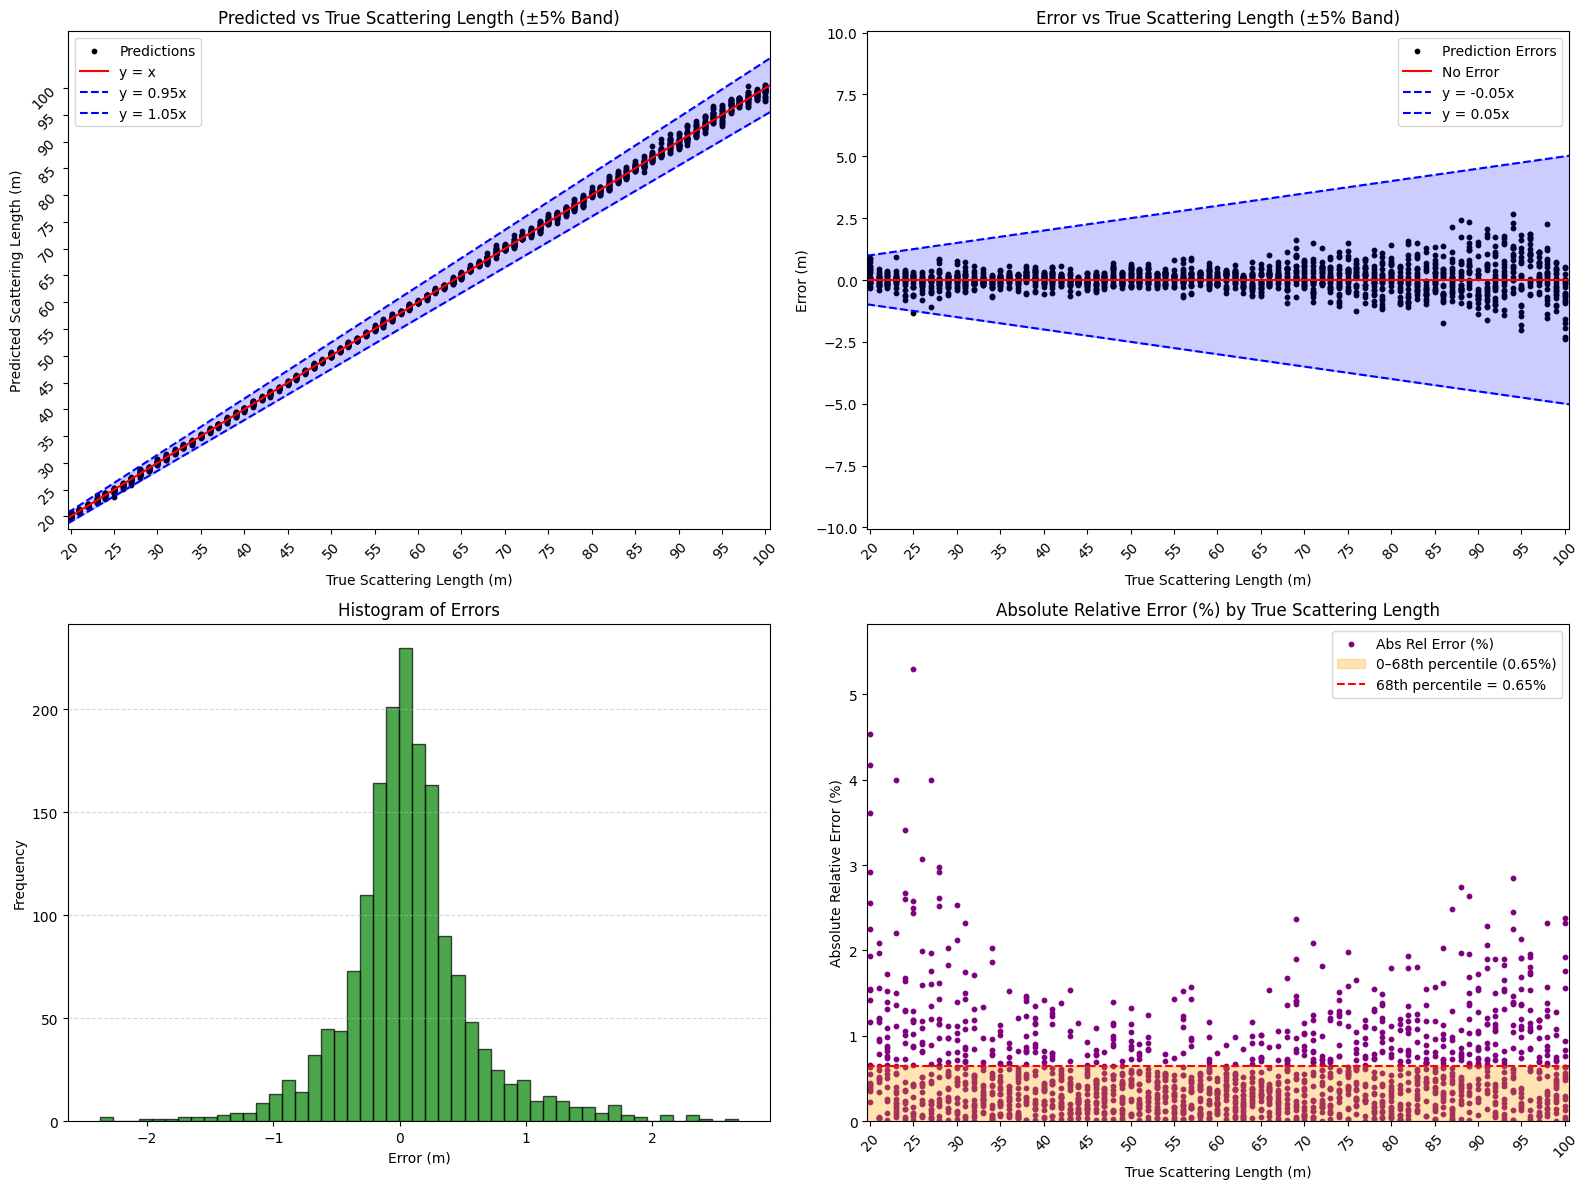

In [32]:
# (G) 결과 시각화 (값을 ×100 스케일로 표시)
plt.figure(figsize=(16, 12))

# 원본 값들은 (예: 0.20, 0.22, …)  m 단위라고 가정
# 이 값들을 플롯할 때 *100 해서 (예: 20, 22, …) m 단위로 보이게 함
true_m = true_vals * 1     # (예: [0.20, 0.22, …] → [20, 22, …])
pred_m = pred_vals * 1     # 예: 예측값도 동일하게 100배
err_m  = errors * 1      # 오차도 100배
# abs_rel_errors(%)은 그대로 퍼센트 단위이므로 변경하지 않음

# 이제 mn, mx도 100배하여 플롯 범위 계산
mn100 = min(true_m.min(), pred_m.min())
mx100 = max(true_m.max(), pred_m.max())

# “뛰엄뛰엄” 눈금(5개 간격)을 원본 unique_true_labels 기반이 아니라, 100배된 true_m 기준으로 계산
unique_m = np.unique(true_m)               # 예: [20, 22, 24, …]
tick_idx = np.arange(0, len(unique_m), 5)  # 0, 5, 10, … 인덱스
xticks = unique_m[tick_idx]                # 예: [20, 30, 40, …]

# 1) Predicted vs True (±5% Band)
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(true_m, pred_m, s=10, color='black', label='Predictions')
ax1.plot([mn100, mx100], [mn100, mx100], color='red', label='y = x')
ax1.plot([mn100, mx100], [0.95*mn100, 0.95*mx100], '--', color='blue', label='y = 0.95x')
ax1.plot([mn100, mx100], [1.05*mn100, 1.05*mx100], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn100, mx100],
                 [0.95*mn100, 0.95*mx100],
                 [1.05*mn100, 1.05*mx100],
                 color='blue', alpha=0.2)

# x축과 y축 눈금을 “5개 간격”으로 설정
ax1.set_xticks(xticks)
ax1.set_xticklabels([f"{val:.0f}" for val in xticks], rotation=45)
ax1.set_yticks(xticks)
ax1.set_yticklabels([f"{val:.0f}" for val in xticks], rotation=45)

ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (m)")
ax1.set_ylabel("Predicted Scattering Length (m)")
ax1.set_xlim(mn100, mx100)
ax1.set_ylim(mn100 * 0.9, mx100 * 1.1)
ax1.legend()


# 2) Error vs True (±5% Band)
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(true_m, err_m, s=10, color='black', label='Prediction Errors')
ax2.plot([mn100, mx100], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn100, mx100], [-0.05*mn100, -0.05*mx100], '--', color='blue', label='y = -0.05x')
ax2.plot([mn100, mx100], [0.05*mn100, 0.05*mx100], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn100, mx100],
                 [-0.05*mn100, -0.05*mx100],
                 [0.05*mn100, 0.05*mx100],
                 color='blue', alpha=0.2)

ax2.set_xticks(xticks)
ax2.set_xticklabels([f"{val:.0f}" for val in xticks], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (m)")
ax2.set_ylabel("Error (m)")
ax2.set_xlim(mn100, mx100)
ax2.set_ylim(-0.1 * mx100, 0.1 * mx100)
ax2.legend()


# 3) Histogram of Errors (50 bins) – 여기서는 에러(err_m)가 이미 m 단위로 스케일링되어 있음
ax3 = plt.subplot(2, 2, 3)
bins = np.linspace(err_m.min(), err_m.max(), 50)
ax3.hist(err_m, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (m)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)


# 4) Absolute Relative Error (%) by True with 68th Percentile
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(true_m, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
perc68 = np.percentile(abs_rel_errors, 68)
ax4.fill_between([mn100, mx100],
                 0, perc68,
                 color='orange', alpha=0.3,
                 label=f'0–68th percentile ({perc68:.2f}%)')
ax4.hlines(perc68, mn100, mx100, colors='red', linestyles='--',
           label=f'68th percentile = {perc68:.2f}%')

ax4.set_xticks(xticks)
ax4.set_xticklabels([f"{val:.0f}" for val in xticks], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (m)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn100, mx100)
ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
ax4.legend()

plt.tight_layout()
plt.show()


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# ... (예측 코드 부분 동일) ...

# 그래프 크기 등 설정
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())
unique_true_labels = np.unique(true_vals)

# 1) Predicted vs True with ±5% Band
ax1 = axes[0, 0]
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()
fig.savefig("pred_vs_true.png", dpi=300, bbox_inches='tight')

# 2) Error vs True with ±5% Band
ax2 = axes[0, 1]
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()
fig.savefig("error_vs_true.png", dpi=300, bbox_inches='tight')

# 3) Histogram of Errors (50 bins)
ax3 = axes[1, 0]
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)
fig.savefig("error_histogram.png", dpi=300, bbox_inches='tight')

# 4) Absolute Relative Error (%) by True with 68th Percentile (binning)
ax4 = axes[1, 1]
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')

# 비닝 및 68% percentile range 표시
bins_centers = unique_true_labels
perc68s = []
for lbl in bins_centers:
    mask = np.isclose(true_vals, lbl, atol=1e-6)
    if np.any(mask):
        perc68 = np.percentile(abs_rel_errors[mask], 68)
        perc68s.append(perc68)
        ax4.vlines(lbl, 0, perc68, color='orange', lw=6, alpha=0.5)  # 68% 구간 라인
    else:
        perc68s.append(0)

ax4.plot(bins_centers, perc68s, color='red', lw=2, label='68th percentile')
ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
ax4.legend()
fig.savefig("abs_rel_error_vs_true.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.close(fig)

# 각각 따로 저장된 파일:
#   pred_vs_true.png
#   error_vs_true.png
#   error_histogram.png
#   abs_rel_error_vs_true.png


In [1]:
# (1) Predicted vs True with ±5% Band
plt.figure(figsize=(6, 5))
ax1 = plt.gca()
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()
plt.tight_layout()
plt.show()

# (2) Error vs True with ±5% Band
plt.figure(figsize=(6, 5))
ax2 = plt.gca()
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()
plt.tight_layout()
plt.show()

# (3) Histogram of Errors (50 bins)
plt.figure(figsize=(6, 5))
ax3 = plt.gca()
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# (4) Absolute Relative Error (%) by True with 68th Percentile (비닝별로)
plt.figure(figsize=(6, 5))
ax4 = plt.gca()
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')

# 68퍼센트 라인 비닝별로
perc68s = []
for lbl in unique_true_labels:
    mask = np.isclose(true_vals, lbl, atol=1e-6)
    if np.any(mask):
        perc68 = np.percentile(abs_rel_errors[mask], 90)
        perc68s.append(perc68)
        #ax4.vlines(lbl, 0, perc68, color='orange', lw=6, alpha=0.5)
    else:
        perc68s.append(0)
ax4.plot(unique_true_labels, perc68s, color='red', lw=2, label='68th percentile')
ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(bottom=0)
ax4.legend()
plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

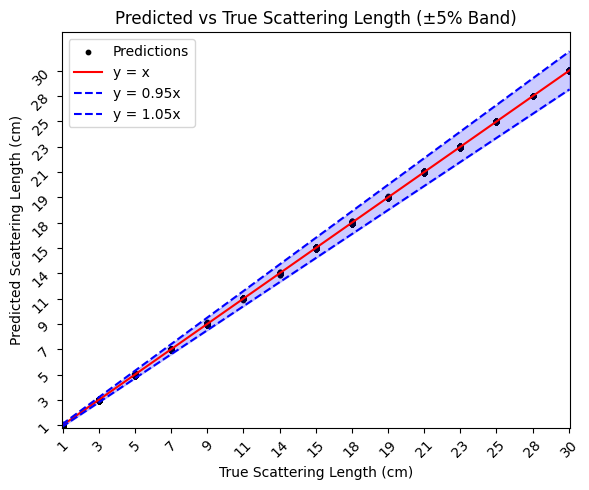

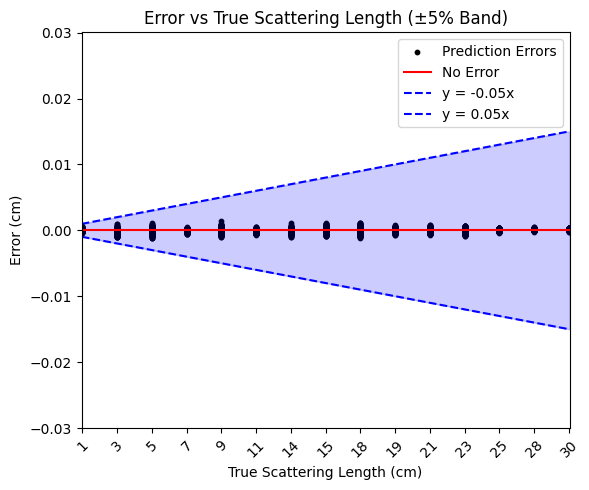

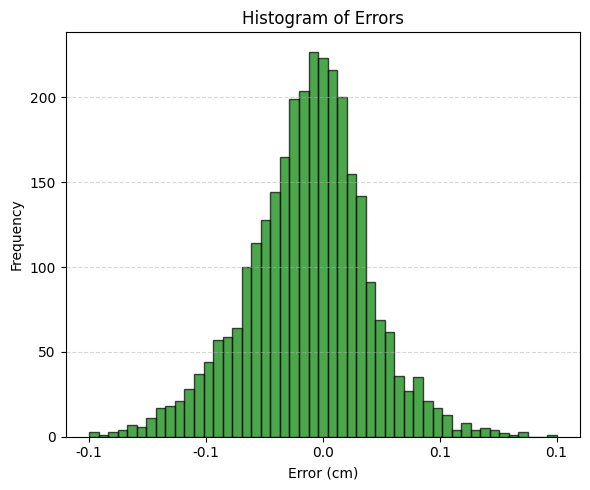

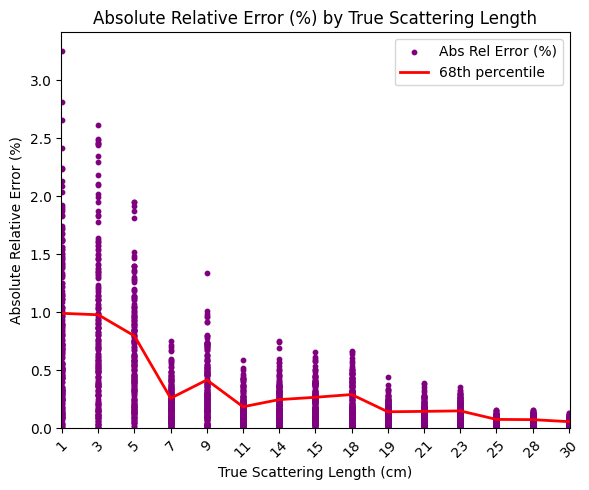

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------
# (가정) 
# true_vals, pred_vals, errors, abs_rel_errors, unique_true_labels, mn, mx
# 는 모두 "m" 단위 (예: 0.02, 0.04, …) 라고 합시다.
# ---------------------------------------------------

# ─────────────────────────────────────────────────────────────────────────────
# 1) Predicted vs True with ±5% Band (눈금은 cm 단위로 표시)
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(6, 5))
ax1 = plt.gca()

# (내부 연산은 m 단위 그대로)
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx],
                 [0.95*mn, 0.95*mx],
                 [1.05*mn, 1.05*mx],
                 color='blue', alpha=0.2)

# 눈금(ticks)을 cm 단위로 변환해서 레이블에 표시
xticks_m = unique_true_labels         # 예: [0.02, 0.04, 0.06, …, 0.30]
xticks_cm = xticks_m * 100            # 예: [2, 4, 6, …, 30]
ax1.set_xticks(xticks_m)
ax1.set_xticklabels([f"{int(val)}" for val in xticks_cm], rotation=45)

# y축도 동일하게
yticks_m = unique_true_labels
yticks_cm = yticks_m * 100
ax1.set_yticks(yticks_m)
ax1.set_yticklabels([f"{int(val)}" for val in yticks_cm], rotation=45)

ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()
plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────────────────────────────────────
# 2) Error vs True with ±5% Band (눈금은 cm 단위로 표시)
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(6, 5))
ax2 = plt.gca()

# 내부 연산은 m 단위 그대로
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx],
                 [-0.05*mn, -0.05*mx],
                 [0.05*mn, 0.05*mx],
                 color='blue', alpha=0.2)

# x축 눈금을 cm 단위로 변환
ax2.set_xticks(xticks_m)
ax2.set_xticklabels([f"{int(val)}" for val in xticks_cm], rotation=45)

ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()
plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────────────────────────────────────
# 3) Histogram of Errors (50 bins) (눈금은 cm 단위로 표시)
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(6, 5))
ax3 = plt.gca()

# Error (m) → Histogram bin 설정
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')

ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")

# x축 눈금을 적절히 선택하여 cm 단위로 표시
# 예: errors.min()=−0.005, errors.max()=0.005 정도라면 [−0.005, −0.0025, 0, 0.0025, 0.005]
# 눈금마다 m→cm로 환산: [−0.5, −0.25, 0, 0.25, 0.5] (cm)
xticks_err_m = np.linspace(errors.min(), errors.max(), 5)
xticks_err_cm = xticks_err_m * 100
ax3.set_xticks(xticks_err_m)
ax3.set_xticklabels([f"{val:.1f}" for val in xticks_err_cm])

ax3.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────────────────────────────────────
# 4) Absolute Relative Error (%) by True with 68th Percentile (눈금은 cm 단위로 표시)
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(6, 5))
ax4 = plt.gca()

ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')

# 각 레이블(예: 0.02, 0.04, …)별로 68% percentile 계산
perc68s = []
for lbl_m in unique_true_labels:
    mask = np.isclose(true_vals, lbl_m, atol=1e-6)
    if np.any(mask):
        perc68 = np.percentile(abs_rel_errors[mask], 68)
        perc68s.append(perc68)
    else:
        perc68s.append(0)

ax4.plot(unique_true_labels, perc68s, color='red', lw=2, label='68th percentile')

# x축 눈금을 cm 단위로 변환
ax4.set_xticks(xticks_m)
ax4.set_xticklabels([f"{int(val)}" for val in xticks_cm], rotation=45)

ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(bottom=0)
ax4.legend()
plt.tight_layout()
plt.show()


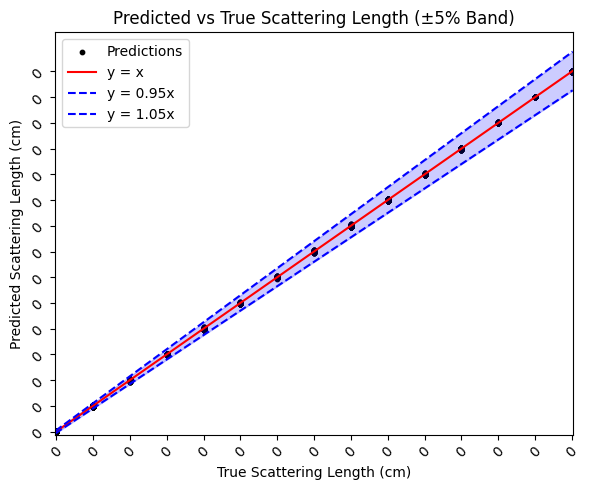

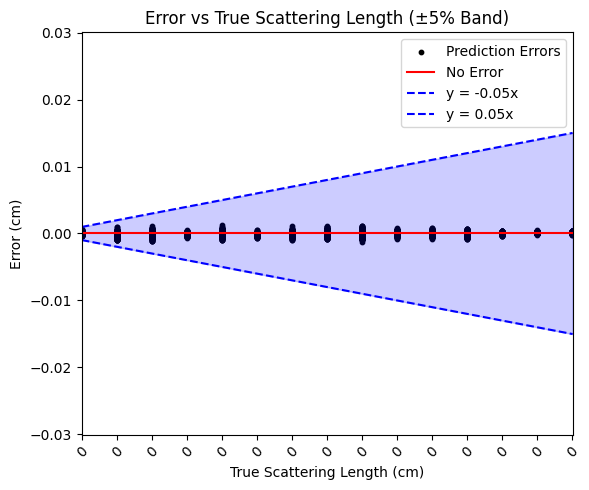

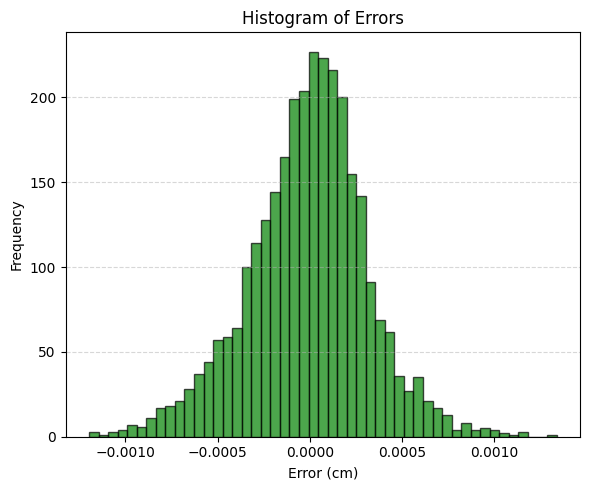

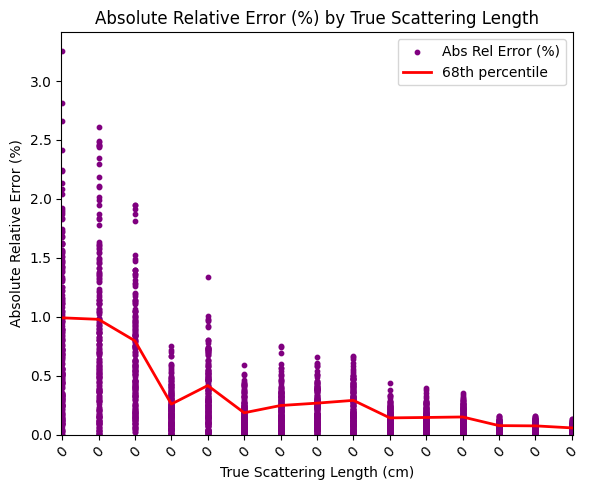

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# true_vals, pred_vals, errors, abs_rel_errors, unique_true_labels, mn, mx 는 모두 'cm' 단위로 가정합니다.

# (1) Predicted vs True with ±5% Band (단위: cm)
plt.figure(figsize=(6, 5))
ax1 = plt.gca()
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx],
                 [0.95*mn, 0.95*mx],
                 [1.05*mn, 1.05*mx],
                 color='blue', alpha=0.2)

# 틱 레이블을 'cm' 단위로 포맷 (예: 2.00 → "2")
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.0f}" for val in unique_true_labels], rotation=45)
ax1.set_yticks(unique_true_labels)
ax1.set_yticklabels([f"{val:.0f}" for val in unique_true_labels], rotation=45)

ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()
plt.tight_layout()
plt.show()

# (2) Error vs True with ±5% Band (단위: cm)
plt.figure(figsize=(6, 5))
ax2 = plt.gca()
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx],
                 [-0.05*mn, -0.05*mx],
                 [0.05*mn, 0.05*mx],
                 color='blue', alpha=0.2)

ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.0f}" for val in unique_true_labels], rotation=45)

ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()
plt.tight_layout()
plt.show()

# (3) Histogram of Errors (단위: cm)
plt.figure(figsize=(6, 5))
ax3 = plt.gca()
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# (4) Absolute Relative Error (%) by True with 68th Percentile (단위: cm)
plt.figure(figsize=(6, 5))
ax4 = plt.gca()
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')

# 각 레이블마다 68% percentile 계산
perc68s = []
for lbl in unique_true_labels:
    mask = np.isclose(true_vals, lbl, atol=1e-6)
    if np.any(mask):
        perc68 = np.percentile(abs_rel_errors[mask], 68)
        perc68s.append(perc68)
    else:
        perc68s.append(0)

ax4.plot(unique_true_labels, perc68s, color='red', lw=2, label='68th percentile')

ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.0f}" for val in unique_true_labels], rotation=45)

ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(bottom=0)
ax4.legend()
plt.tight_layout()
plt.show()


In [17]:
import numpy as np
import pandas as pd

# pred_vals, true_vals: (N,) numpy array (이미 준비되어 있다고 가정)
# unique_labels: np.unique(true_vals) (라벨 후보, float/정수 상관없음)

results = []
for lbl in unique_true_labels:
    idx = np.where(true_vals == lbl)[0]
    errs = pred_vals[idx] - true_vals[idx]
    rel_errs = np.abs(errs / true_vals[idx]) * 100

    mean_err = np.mean(errs)
    mean_rel_err = np.mean(rel_errs)
    # 90% range: 5th–95th percentile (central 90%)
    range90_err = np.percentile(errs, [5, 95])
    range90_rel_err = np.percentile(rel_errs, [5, 95])
    range90_err_val = f"±{(range90_err[1]-range90_err[0])/2:.3f}"
    range90_rel_err_val = f"{(range90_rel_err[1]-range90_rel_err[0]):.3f}"

    results.append({
        "Scattering Length (cm)": lbl,
        "Mean Error (cm)": f"{mean_err:.3f}",
        "Mean Relative Error (%)": f"{mean_rel_err:.3f}",
        "90% Range of Error (cm)": range90_err_val,
        "90% Range of Relative Error (%)": range90_rel_err_val,
    })

# 전체(총계)도 계산
errs = pred_vals - true_vals
rel_errs = np.abs(errs / true_vals) * 100
mean_err = np.mean(errs)
mean_rel_err = np.mean(rel_errs)
range90_err = np.percentile(errs, [5, 95])
range90_rel_err = np.percentile(rel_errs, [5, 95])
range90_err_val = f"±{(range90_err[1]-range90_err[0])/2:.3f}"
range90_rel_err_val = f"{(range90_rel_err[1]-range90_rel_err[0]):.3f}"

results.append({
    "Scattering Length (cm)": "Total",
    "Mean Error (cm)": f"{mean_err:.3f}",
    "Mean Relative Error (%)": f"{mean_rel_err:.3f}",
    "90% Range of Error (cm)": range90_err_val,
    "90% Range of Relative Error (%)": range90_rel_err_val,
})

df = pd.DataFrame(results)
print(df)


   Scattering Length (cm) Mean Error (cm) Mean Relative Error (%)  \
0                    0.02           0.000                   0.800   
1                    0.04          -0.000                   0.795   
2                    0.06          -0.000                   0.613   
3                    0.08          -0.000                   0.223   
4                     0.1          -0.000                   0.333   
5                    0.12          -0.000                   0.153   
6                    0.14          -0.000                   0.199   
7                    0.16           0.000                   0.211   
8                    0.18          -0.000                   0.217   
9                     0.2           0.000                   0.113   
10                   0.22           0.000                   0.112   
11                   0.24          -0.000                   0.117   
12                   0.26           0.000                   0.056   
13                   0.28         